## Data Setup and Selection Cuts

The datasets are read from CSV files and combined for inspection. We then apply the following selection criteria (without cutting on the variable *reco_zv_mass*):

$$
\begin{aligned}
0.1 \times 10^6 < &\; \text{lep1\_pt} < 0.7 \times 10^6,\\[2mm]
&\; \text{lep2\_pt} < 0.45 \times 10^6,\\[2mm]
&\; \text{fatjet\_pt} < 0.8 \times 10^6,\\[2mm]
&\; \text{fatjet\_D2} < 2,\\[2mm]
0.075 \times 10^6 < &\; \text{Zll\_mass} < 0.11 \times 10^6,\\[2mm]
&\; \text{MET} < 0.1 \times 10^6,\\[2mm]
0.3 \times 10^6 < &\; \text{Zll\_pt} < 0.8 \times 10^6.
\end{aligned}
$$

All kinematic distributions are then plotted for a set of variables to inspect the effects of these cuts. The event weights (`FullEventWeight`) are used to normalize the contributions from each process.


Column Names and Data Types:
Unnamed: 0           int64
FullEventWeight    float64
MET                float64
Topology             int64
Zll_mass           float64
Zll_pt             float64
fatjet_C2          float64
fatjet_D2          float64
fatjet_E           float64
fatjet_eta         float64
fatjet_phi         float64
fatjet_pt          float64
isSignal             int64
lep1_E             float64
lep1_charge          int64
lep1_eta           float64
lep1_phi           float64
lep1_pt            float64
lep2_E             float64
lep2_charge          int64
lep2_eta           float64
lep2_phi           float64
lep2_pt            float64
reco_zv_mass       float64
truth_zv_mass      float64
dtype: object

Number of Entries in Each Column:
Unnamed: 0         6876972
FullEventWeight    6876972
MET                6876972
Topology           6876972
Zll_mass           6876972
Zll_pt             6876972
fatjet_C2          6876972
fatjet_D2          6876972
fatjet_E           6876972
fatj

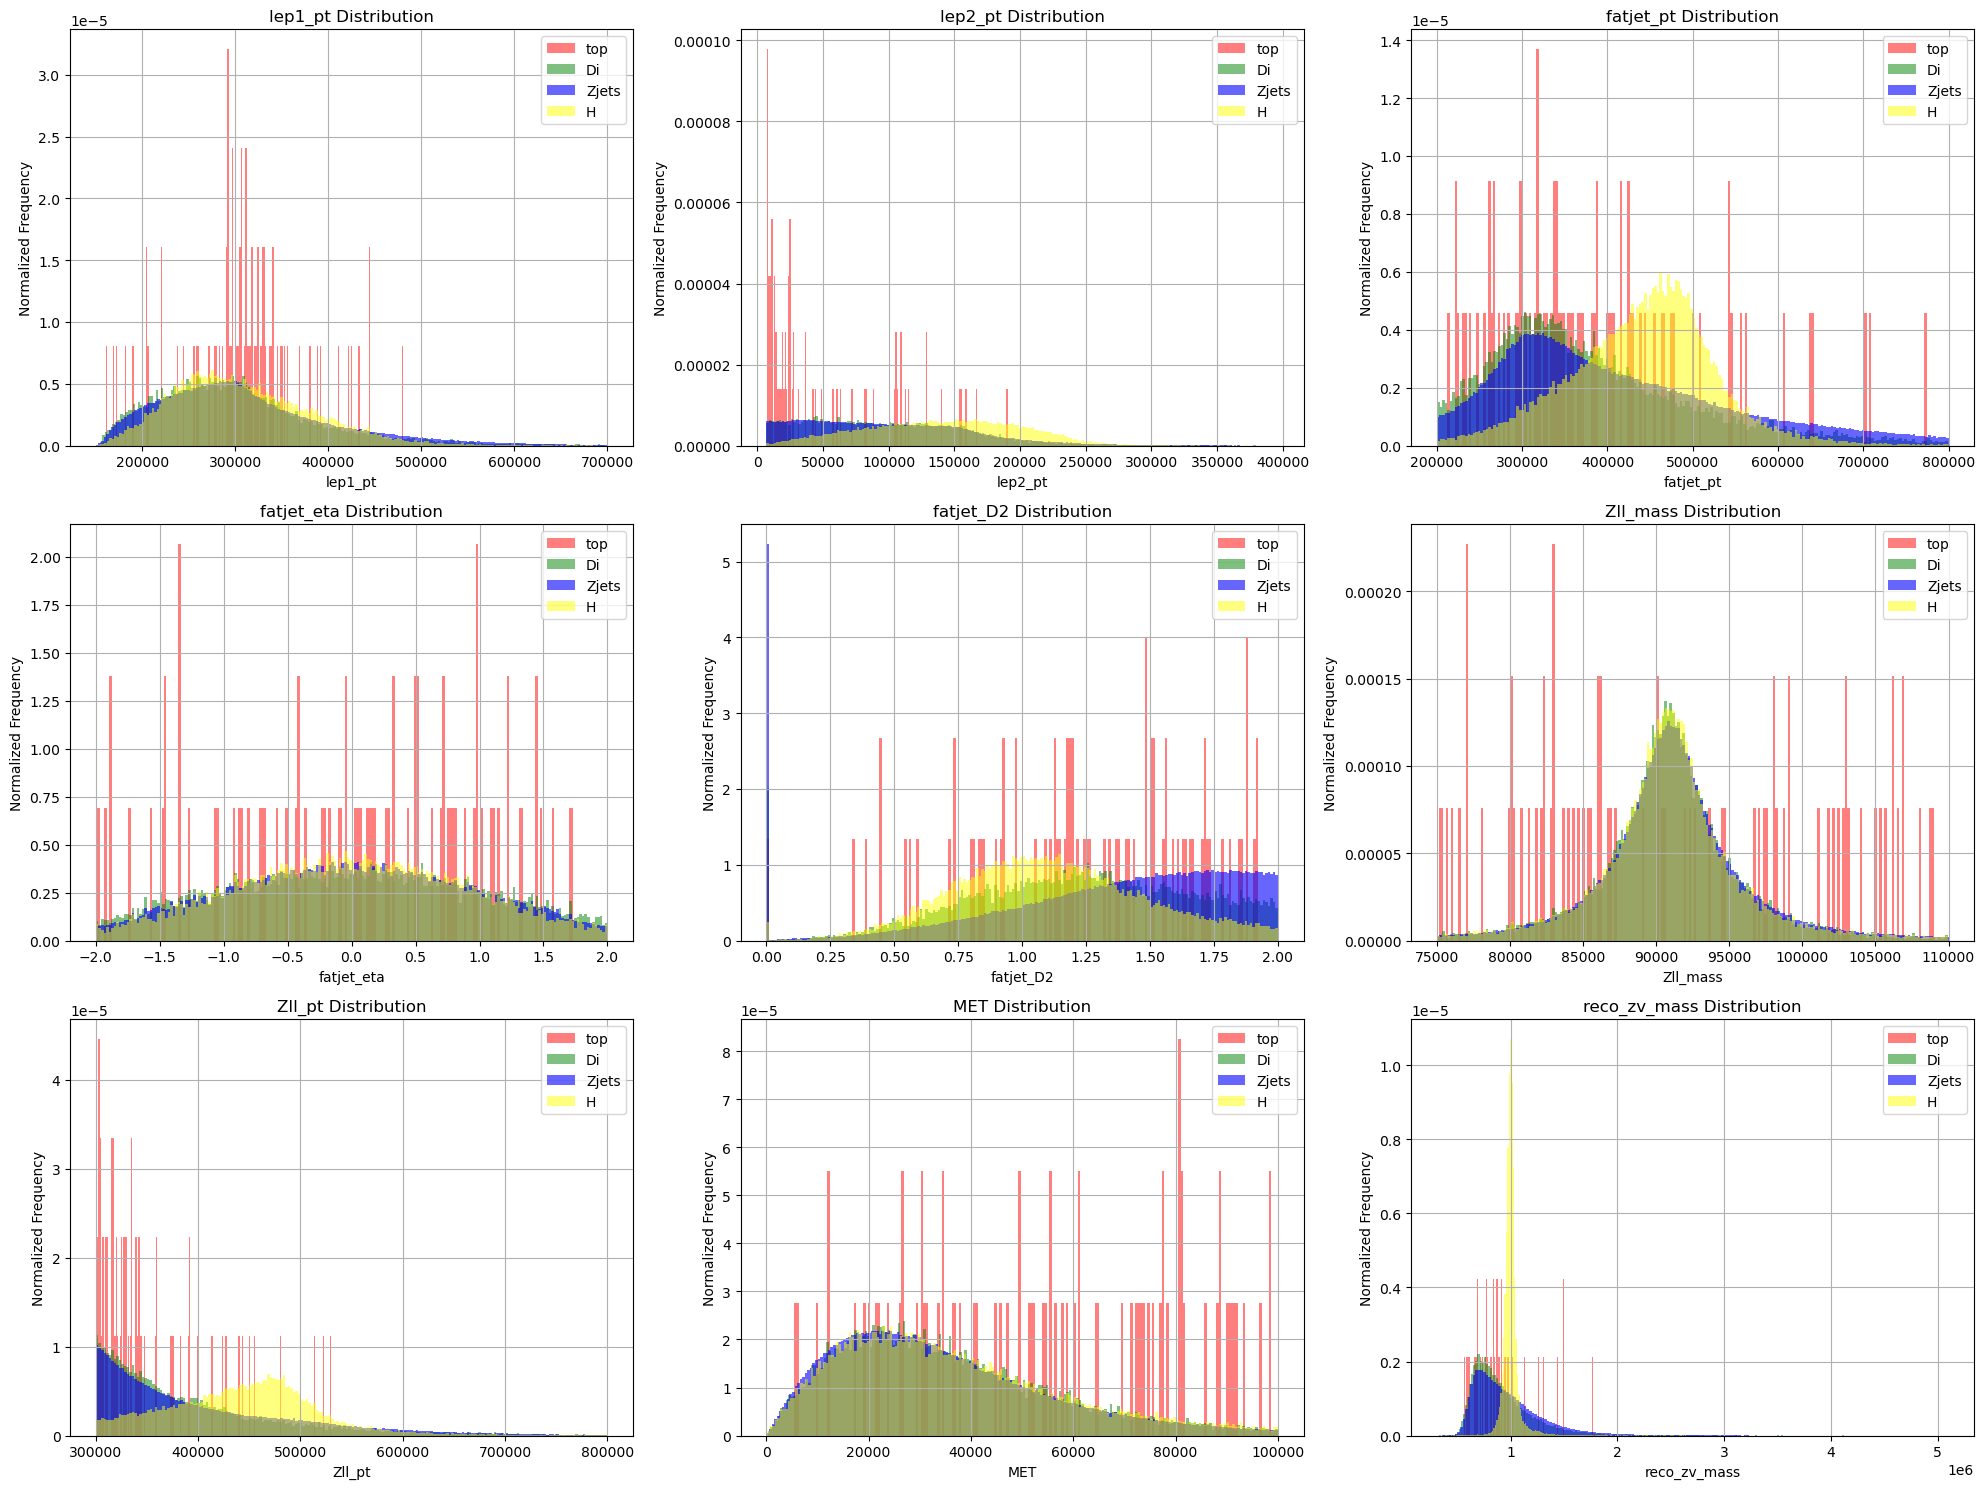

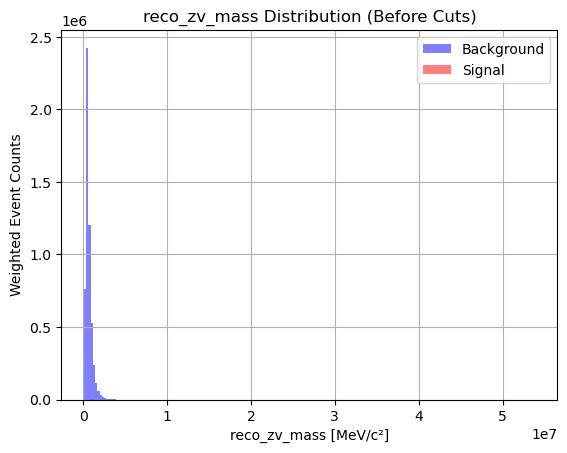

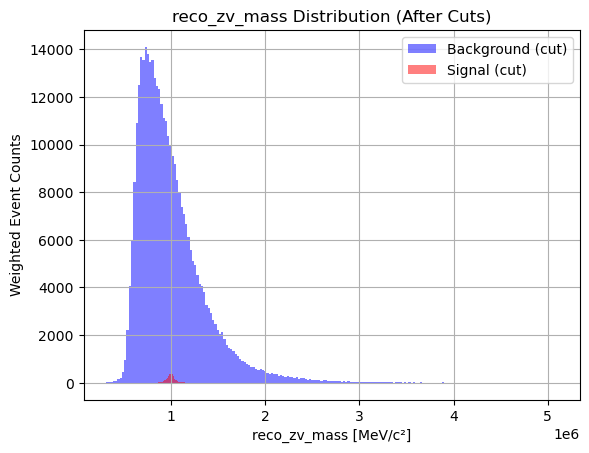

--- Total Weighted Events ---
Before Cuts:
 - Background: 5402673.57
 - Signal: 4200.16
After Cuts:
 - Background: 361078.37
 - Signal: 2936.56


In [4]:
# ============================================================
# Import Modules 
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from iminuit import Minuit
from keras.models import Sequential
from keras.layers import Dropout, Input, Dense
from keras.wrappers import SKLearnRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import accuracy_score

# ============================================================
# Task 1 – Setup and Data Inspection
# ============================================================

# Read in the datasets
zjets_df = pd.read_csv('C:/Users/jonat/Downloads/Zjets.csv')
top_df   = pd.read_csv('C:/Users/jonat/Downloads/Top.csv')
di_df    = pd.read_csv('C:/Users/jonat/Downloads/Diboson.csv')
h_df     = pd.read_csv('C:/Users/jonat/Downloads/ggH1000.csv')

# Combine all datasets for global checks.
all_df = pd.concat([top_df, h_df, di_df, zjets_df], ignore_index=True)

print("Column Names and Data Types:")
print(all_df.dtypes)
print("\nNumber of Entries in Each Column:")
print(all_df.count())
print("\nNull Values Per Column:")
print(all_df.isnull().sum())

# ============================================================
# Task 1a – Apply Selection Cuts and Plot Kinematic Distributions
# ============================================================

# Define the selection cuts 
selection_str = (
    'lep1_pt < 0.7e6 and lep1_pt > 0.1e6 and '
    'lep2_pt < 0.45e6 and '
    'fatjet_pt < 0.8e6 and '
    'fatjet_D2 < 2 and '
    'Zll_mass < 0.11e6 and '
    'MET < 0.1e6 and '
    'Zll_pt < 0.8e6 and '
    'Zll_pt > 0.3e6 and '
    'Zll_mass > 0.075e6'
)
# Apply the selection cuts on each dataset
zjets_cut_df = zjets_df.query(selection_str)
top_cut_df   = top_df.query(selection_str)
di_cut_df    = di_df.query(selection_str)
h_cut_df     = h_df.query(selection_str)

# Plot the kinematic distributions for a set of key variables.
var_names = ["lep1_pt", "lep2_pt", "fatjet_pt", "fatjet_eta", "fatjet_D2", "Zll_mass", "Zll_pt", "MET", "reco_zv_mass"]
n_bins = 200

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, var in enumerate(var_names):
    axs[i].hist(top_cut_df[var], bins=n_bins, density=True, label='top', color='red', alpha=0.5)
    axs[i].hist(di_cut_df[var], bins=n_bins, density=True, label='Di', color='green', alpha=0.5)
    axs[i].hist(zjets_cut_df[var], bins=n_bins, density=True, label='Zjets', color='blue', alpha=0.6)
    axs[i].hist(h_cut_df[var], bins=n_bins, density=True, label='H', color='yellow', alpha=0.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Normalized Frequency')
    axs[i].set_title(f'{var} Distribution')
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

# ============================================================
# Task 1b – Normalisation using FullEventWeight and Event Counting
# ============================================================

# Define background and signal datasets for the entire dataset.
bkg_df = all_df[all_df['isSignal'] == 0]
sig_df = all_df[all_df['isSignal'] == 1]

# Define the cut dataset by concatenating the individual cut datasets.
cut_df = pd.concat([top_cut_df, h_cut_df, di_cut_df, zjets_cut_df], ignore_index=True)
bkg_cut_df = cut_df[cut_df['isSignal'] == 0]
sig_cut_df = cut_df[cut_df['isSignal'] == 1]

# Plot the weighted reco_zv_mass distribution BEFORE cuts.
plt.hist(bkg_df['reco_zv_mass'], bins=n_bins, histtype='stepfilled',
         alpha=0.5, weights=bkg_df['FullEventWeight'], color='blue', label='Background')
plt.hist(sig_df['reco_zv_mass'], bins=n_bins, histtype='stepfilled',
         alpha=0.5, weights=sig_df['FullEventWeight'], color='red', label='Signal')
plt.xlabel('reco_zv_mass [MeV/c²]')
plt.ylabel('Weighted Event Counts')
plt.title('reco_zv_mass Distribution (Before Cuts)')
plt.legend()
plt.grid()
plt.show()

# Plot the weighted reco_zv_mass distribution AFTER cuts.
plt.hist(bkg_cut_df['reco_zv_mass'], bins=n_bins, histtype='stepfilled',
         alpha=0.5, weights=bkg_cut_df['FullEventWeight'], color='blue', label='Background (cut)')
plt.hist(sig_cut_df['reco_zv_mass'], bins=n_bins, histtype='stepfilled',
         alpha=0.5, weights=sig_cut_df['FullEventWeight'], color='red', label='Signal (cut)')
plt.xlabel('reco_zv_mass [MeV/c²]')
plt.ylabel('Weighted Event Counts')
plt.title('reco_zv_mass Distribution (After Cuts)')
plt.legend()
plt.grid()
plt.show()

# Sum the weighted events
bkg_wt_sum = bkg_df['FullEventWeight'].sum()
sig_wt_sum = sig_df['FullEventWeight'].sum()
bkg_cut_wt_sum = bkg_cut_df['FullEventWeight'].sum()
sig_cut_wt_sum = sig_cut_df['FullEventWeight'].sum()

print("--- Total Weighted Events ---\nBefore Cuts:")
print(f" - Background: {bkg_wt_sum:.2f}")
print(f" - Signal: {sig_wt_sum:.2f}\nAfter Cuts:")
print(f" - Background: {bkg_cut_wt_sum:.2f}")
print(f" - Signal: {sig_cut_wt_sum:.2f}")


## Fitting and Hypothesis Testing

### Gaussian and Polynomial Models

We define a Gaussian model to describe the signal:
$$
G(x; N, \mu, \sigma) = N \cdot \frac{1}{\sqrt{2\pi}\,\sigma} \exp\Bigl(-\frac{(x-\mu)^2}{2\sigma^2}\Bigr),
$$
and a cubic polynomial model for the background:
$$
P(x; N, a, b, c, d) = N\cdot\Bigl(a x^3 + b x^2 + c x + d\Bigr).
$$

The chi² value is computed by comparing the weighted bin counts \(w_i\) with the model predictions \(m_i\) over the bins:
$$
\chi^2 = \sum_i \frac{(w_i - m_i)^2}{\sigma_i^2},
$$
where \(\sigma_i^2\) is the sum of squared weights in bin \(i\).

### Hypotheses Testing

Two fits are performed:
- **H₀:** Fit the combined data using only the polynomial model.
- **H₁:** Fit the combined data with a sum of the fixed Gaussian (with parameters determined from the signal-only fit) plus the polynomial model.

The statistical significance is estimated using the difference in chi²:
$$
Z = \sqrt{\Delta \chi^2} = \sqrt{\chi^2(H_0) - \chi^2(H_1)}.
$$


--- Polynomial Fit on Background + Signal Data ---


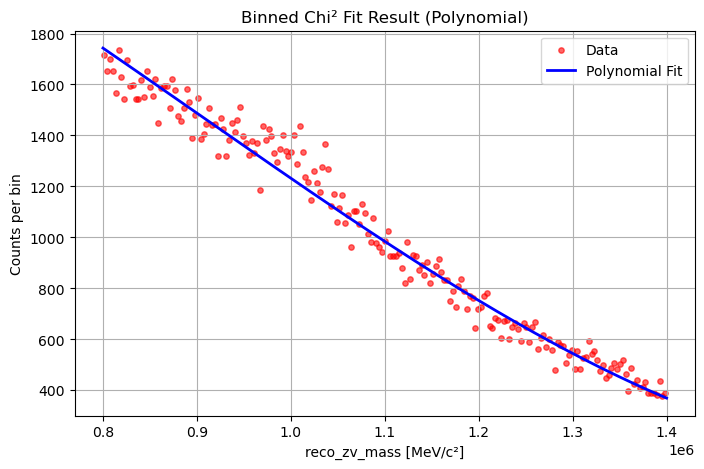

--- Combined Gaussian and Polynomial Fit on Background + Signal Data ---
Best-fit mean: 994,721.7 MeV/c²
Best-fit sigma: 39,640.0 MeV


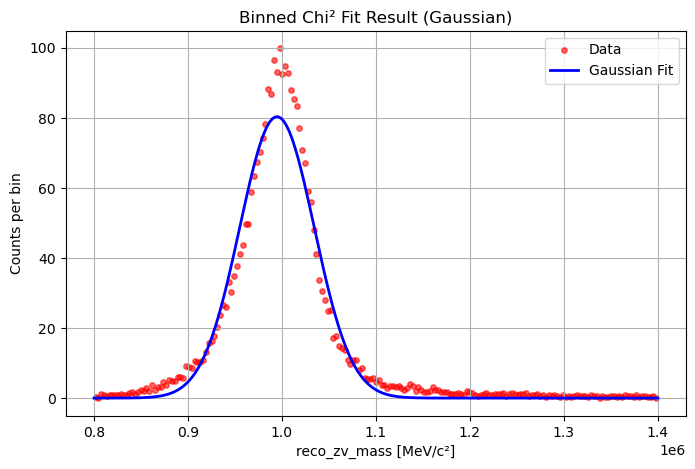

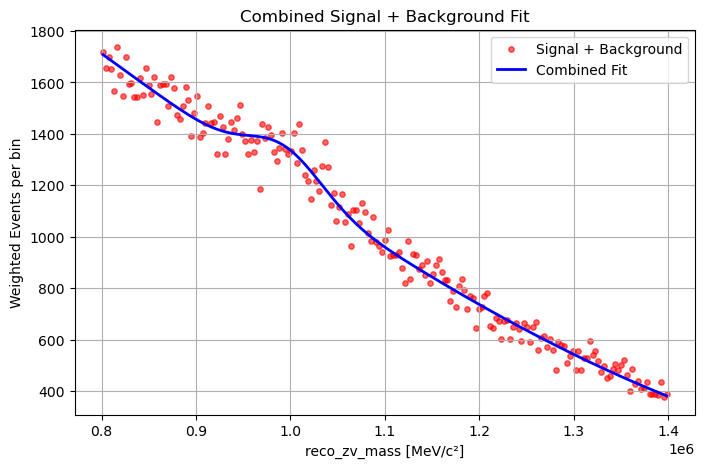

Chi²(H₀): 318.95
Chi²(H₁): 222.10
Δχ²: 96.85
Statistical Significance (Z): 9.84 sigma


In [6]:
# ============================================================
# Task 2 – Fitting and Hypothesis Testing
# ============================================================

# Define the fitting mass range.
fit_mass_min = 0.8e6
fit_mass_max = 1.4e6
mass_selection_str = f"reco_zv_mass > {fit_mass_min} and reco_zv_mass < {fit_mass_max}"

# Apply the mass range selection to the signal and background cut data.
signal_fit_df = sig_cut_df.query(mass_selection_str)
background_fit_df = bkg_cut_df.query(mass_selection_str)

# Define bin edges for the fits.
mass_bins = np.linspace(fit_mass_min, fit_mass_max, n_bins)

# --- Define utility functions for fitting ---
def compute_hist_props(bins_array, data_df):
    """
    Compute histogram properties and weighted counts.
    """
    total_bins = len(bins_array)
    bin_width = bins_array[1] - bins_array[0]
    _, computed_edges = np.histogram(data_df['reco_zv_mass'], bins=bins_array)
    bin_centers = (computed_edges[:-1] + computed_edges[1:]) / 2
    w_counts, _ = np.histogram(data_df['reco_zv_mass'], bins=bins_array, weights=data_df['FullEventWeight'])
    w_counts_sq, _ = np.histogram(data_df['reco_zv_mass'], bins=bins_array, weights=data_df['FullEventWeight']**2)
    return total_bins, bin_centers, w_counts, w_counts_sq, bin_width

def compute_chi2_val(w_counts, w_counts_sq, model_vals):
    """
    Compute the chi² value.
    """
    return np.sum(((w_counts - model_vals)**2) / (w_counts_sq + 1e-9))

def create_chi2_func(centers, w_counts, w_counts_sq, width, model_type):
    """
    Return the chi² function for either a Gaussian ('g') or a polynomial ('p') model.
    """
    if model_type == 'g':
        def chi2_gaussian(ampl, mean, std_dev):
            prediction = gauss_model(centers, ampl, mean, std_dev) * width
            return compute_chi2_val(w_counts, w_counts_sq, prediction)
        return chi2_gaussian
    elif model_type == 'p':
        def chi2_polynomial(ampl, coef_a, coef_b, coef_c, coef_d):
            prediction = poly_model(centers, ampl, coef_a, coef_b, coef_c, coef_d) * width
            return compute_chi2_val(w_counts, w_counts_sq, prediction)
        return chi2_polynomial

# --- Define the model functions ---
def gauss_model(x, ampl, mean, std_dev):
    """Gaussian model for the signal."""
    return ampl * norm.pdf(x, mean, std_dev)

def poly_model(x, ampl, coef_a, coef_b, coef_c, coef_d):
    """Cubic polynomial model for the background."""
    return ampl * (coef_a * x**3 + coef_b * x**2 + coef_c * x + coef_d)

# --- Define the fit functions ---
def fit_poly_model(bins_array, data_df):
    """
    Fit a polynomial model (for background or combined) via chi² minimization.
    """
    total_bins, centers, w_counts, w_counts_sq, width = compute_hist_props(bins_array, data_df)
    chi2_poly = create_chi2_func(centers, w_counts, w_counts_sq, width, 'p')
    minuit_poly = Minuit(chi2_poly, ampl=1, coef_a=0, coef_b=0, coef_c=0, coef_d=np.mean(w_counts))
    minuit_poly.limits["ampl"] = (0, None)
    minuit_poly.limits["coef_c"] = (0, None)
    minuit_poly.limits["coef_d"] = (0, None)
    minuit_poly.simplex()
    minuit_poly.migrad(ncall=100_000)
    fitted_a = minuit_poly.values['coef_a']
    fitted_b = minuit_poly.values['coef_b']
    fitted_c = minuit_poly.values['coef_c']
    fitted_d = minuit_poly.values['coef_d']
    chi2_null = minuit_poly.fval
    hist_counts, _ = np.histogram(data_df['reco_zv_mass'], bins=bins_array, weights=data_df['FullEventWeight'])
    plt.figure(figsize=(8, 5))
    plt.scatter(centers, hist_counts, color='red', alpha=0.6, s=15, label='Data')
    x_vals = np.linspace(bins_array[0], bins_array[-1], total_bins)
    poly_fit_vals = poly_model(x_vals, *minuit_poly.values) * width
    plt.plot(x_vals, poly_fit_vals, 'b-', linewidth=2, label='Polynomial Fit')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Counts per bin')
    plt.title('Binned Chi² Fit Result (Polynomial)')
    plt.legend()
    plt.grid(True)
    plt.show()
    return chi2_null, fitted_a, fitted_b, fitted_c, fitted_d

def fit_gauss_model(bins_array, data_df):
    """
    Fit a Gaussian model to the signal-only data.
    """
    total_bins, centers, w_counts, w_counts_sq, width = compute_hist_props(bins_array, data_df)
    init_mean = np.sum(centers * w_counts) / np.sum(w_counts)
    init_var = np.sum(w_counts * (centers - init_mean)**2) / np.sum(w_counts)
    init_std = np.sqrt(init_var) if init_var > 0 else 1e5
    chi2_gauss = create_chi2_func(centers, w_counts, w_counts_sq, width, 'g')
    minuit_gauss = Minuit(chi2_gauss, ampl=np.sum(w_counts), mean=init_mean, std_dev=init_std)
    minuit_gauss.limits["ampl"] = (0, None)
    minuit_gauss.limits["mean"] = (0, None)
    minuit_gauss.limits["std_dev"] = (0, None)
    minuit_gauss.simplex()
    minuit_gauss.migrad(ncall=100_000)
    fixed_mean = minuit_gauss.values['mean']
    fixed_std = minuit_gauss.values['std_dev']
    print(f"Best-fit mean: {fixed_mean:,.1f} MeV/c²")
    print(f"Best-fit sigma: {fixed_std:,.1f} MeV")
    hist_counts, _ = np.histogram(data_df['reco_zv_mass'], bins=bins_array, weights=data_df['FullEventWeight'])
    plt.figure(figsize=(8, 5))
    plt.scatter(centers, hist_counts, color='red', alpha=0.6, s=15, label='Data')
    x_vals = np.linspace(bins_array[0], bins_array[-1], total_bins)
    gauss_fit_vals = gauss_model(x_vals, *minuit_gauss.values) * width
    plt.plot(x_vals, gauss_fit_vals, 'b-', linewidth=2, label='Gaussian Fit')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Counts per bin')
    plt.title('Binned Chi² Fit Result (Gaussian)')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fixed_mean, fixed_std

# --- Define the combined model functions ---
def combined_model_func(centers, fixed_mean, fixed_std, sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d):
    """
    Combined Gaussian (signal) and polynomial (background) model.
    """
    signal_part = gauss_model(centers, sig_ampl, fixed_mean, fixed_std)
    background_part = poly_model(centers, bkg_ampl, coef_a, coef_b, coef_c, coef_d)
    return signal_part + background_part

def chi2_combined(centers, w_counts, w_counts_sq, width, fixed_mean, fixed_std):
    """
    Chi² function for the combined model.
    """
    def chi2_total(sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d):
        model_vals = combined_model_func(centers, fixed_mean, fixed_std, sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d) * width
        return compute_chi2_val(w_counts, w_counts_sq, model_vals)
    return chi2_total

def fit_combined_model(mass_bins, combined_df, init_a, init_b, init_c, init_d, fixed_mean, fixed_std):
    """
    Fit the combined model to the signal-plus-background data.
    """
    total_bins, centers, w_counts, w_counts_sq, width = compute_hist_props(mass_bins, combined_df)
    chi2_total = chi2_combined(centers, w_counts, w_counts_sq, width, fixed_mean, fixed_std)
    minuit_comb = Minuit(chi2_total, sig_ampl=1, bkg_ampl=1, coef_a=init_a, coef_b=init_b, coef_c=init_c, coef_d=init_d)
    minuit_comb.limits["sig_ampl"] = (0, None)
    minuit_comb.limits["bkg_ampl"] = (0, None)
    minuit_comb.simplex()
    minuit_comb.migrad(ncall=100_000_000)
    H1_chi2 = minuit_comb.fval
    model_vals = combined_model_func(centers, fixed_mean, fixed_std, *minuit_comb.values) * width
    hist_counts, _ = np.histogram(combined_df['reco_zv_mass'], bins=mass_bins, weights=combined_df['FullEventWeight'])
    plt.figure(figsize=(8, 5))
    plt.scatter(centers, hist_counts, color='red', alpha=0.6, s=15, label='Signal + Background')
    plt.plot(centers, model_vals, 'b-', linewidth=2, label='Combined Fit')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Weighted Events per bin')
    plt.title('Combined Signal + Background Fit')
    plt.legend()
    plt.grid(True)
    plt.show()
    return H1_chi2

# ------------------------------------------------
# Task 2c: Compute statistical significance using Wilks's Theorem
# ------------------------------------------------

# Combined dataset for fitting (signal + background)
combined_data_df = pd.concat([signal_fit_df, background_fit_df], ignore_index=True)

# First, compute the chi² for the null hypothesis (H₀) using only a polynomial fit.
print("--- Polynomial Fit on Background + Signal Data ---")
H0_chi2, poly_fit_a, poly_fit_b, poly_fit_c, poly_fit_d = fit_poly_model(mass_bins, combined_data_df)

# Next, perform the combined Gaussian+Polynomial fit (H₁).
print("--- Combined Gaussian and Polynomial Fit on Background + Signal Data ---")
fitted_mean, fitted_std = fit_gauss_model(mass_bins, signal_fit_df)
H1_chi2 = fit_combined_model(mass_bins, combined_data_df, poly_fit_a, poly_fit_b, poly_fit_c, poly_fit_d, fitted_mean, fitted_std)

delta_chi2 = H0_chi2 - H1_chi2
significance_Z = np.sqrt(delta_chi2)
print("Chi²(H₀): {:.2f}".format(H0_chi2))
print("Chi²(H₁): {:.2f}".format(H1_chi2))
print("Δχ²: {:.2f}".format(delta_chi2))
print("Statistical Significance (Z): {:.2f} sigma".format(significance_Z))






=== Improved Gaussian Fit (Double Gaussian) on signal_fit_df ===
Best-fit mean: 996,136.7 MeV/c²
Best-fit sigma (effective): 44,530.4 MeV


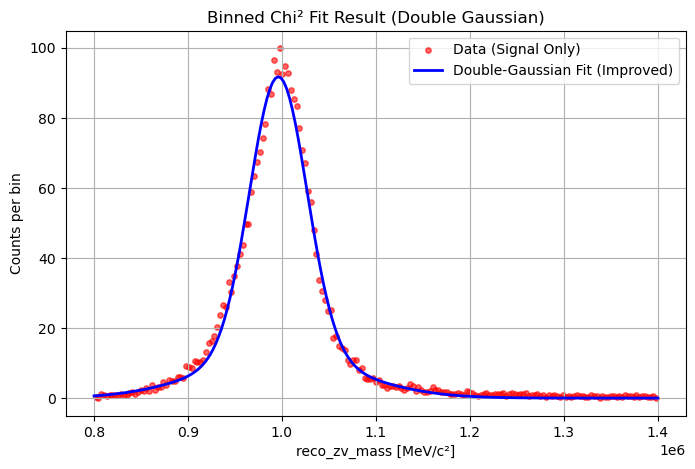

In [9]:
# ================================================
# Cell 1: Improved (Double Gaussian) Fit to Signal-Only Data
# ================================================

def double_gaussian_fn(x_vals, ampl, mu_val, sigma_first, frac_first, sigma_second):
    """
    Double-Gaussian model for the signal:
      - ampl: overall normalization (area)
      - mu_val: common mean
      - sigma_first: width of first Gaussian
      - sigma_second: width of second Gaussian
      - frac_first: fraction for the first Gaussian (0 < frac_first < 1)
    """
    gauss1 = frac_first * norm.pdf(x_vals, mu_val, sigma_first)
    gauss2 = (1.0 - frac_first) * norm.pdf(x_vals, mu_val, sigma_second)
    return ampl * (gauss1 + gauss2)

def make_chi2_double_gaussian_fn(centers, weights_sum, weights_sum_sq, bin_width):
    """
    Return a chi² function for the double-Gaussian model.
    """
    def chi2_double_gaussian(ampl, mu_val, sigma_first, frac_first, sigma_second):
        if not (0 < frac_first < 1):
            return 1e15  # Penalize invalid fraction
        model_prediction = double_gaussian_fn(centers, ampl, mu_val, sigma_first, frac_first, sigma_second) * bin_width
        return compute_chi2_val(weights_sum, weights_sum_sq, model_prediction)
    return chi2_double_gaussian

def fit_double_gaussian_model(bin_edges, data_df):
    """
    Fit the signal-only data using a double-Gaussian model.
    Returns:
      - best_mu: the fitted mean
      - effective_sigma: a single effective sigma (fraction-weighted average)
      - chi2_improved: the chi² value of the fit
    """
    total_bins, centers, weights_sum, weights_sum_sq, bin_width = compute_hist_props(bin_edges, data_df)

    # Compute initial estimates using a single Gaussian
    init_mu = np.sum(centers * weights_sum) / np.sum(weights_sum)
    init_variance = np.sum(weights_sum * (centers - init_mu)**2) / np.sum(weights_sum)
    init_sigma = np.sqrt(init_variance) if init_variance > 0 else 1e5

    # Prepare the chi² function for the double-Gaussian model
    chi2_func = make_chi2_double_gaussian_fn(centers, weights_sum, weights_sum_sq, bin_width)

    # Set up Minuit with initial guesses
    minuit_obj = Minuit(chi2_func,
                        ampl=np.sum(weights_sum),
                        mu_val=init_mu,
                        sigma_first=init_sigma,
                        frac_first=0.5,
                        sigma_second=1.2 * init_sigma)
    
    # Define parameter limits
    minuit_obj.limits["ampl"] = (0, None)
    minuit_obj.limits["mu_val"] = (0, None)
    minuit_obj.limits["sigma_first"] = (0, None)
    minuit_obj.limits["sigma_second"] = (0, None)
    minuit_obj.limits["frac_first"] = (0, 1)
    
    # Perform minimization using simplex and migrad
    minuit_obj.simplex()
    minuit_obj.migrad(ncall=100_000)
    
    # Extract best-fit parameters
    best_ampl = minuit_obj.values["ampl"]
    best_mu = minuit_obj.values["mu_val"]
    best_sigma_first = minuit_obj.values["sigma_first"]
    best_frac_first = minuit_obj.values["frac_first"]
    best_sigma_second = minuit_obj.values["sigma_second"]
    chi2_improved = minuit_obj.fval

    # Compute effective sigma as a fraction-weighted average
    effective_sigma = best_frac_first * best_sigma_first + (1 - best_frac_first) * best_sigma_second

    # Print best-fit parameters
    print(f"Best-fit mean: {best_mu:,.1f} MeV/c²")
    print(f"Best-fit sigma (effective): {effective_sigma:,.1f} MeV")

    # Plot the data vs. the fitted model
    hist_counts, _ = np.histogram(data_df['reco_zv_mass'], bins=bin_edges, weights=data_df['FullEventWeight'])
    
    plt.figure(figsize=(8, 5))
    plt.scatter(centers, hist_counts, color='red', alpha=0.6, s=15, label='Data (Signal Only)')
    
    x_vals = np.linspace(bin_edges[0], bin_edges[-1], total_bins)
    fit_curve = double_gaussian_fn(x_vals, best_ampl, best_mu, best_sigma_first, best_frac_first, best_sigma_second) * bin_width
    plt.plot(x_vals, fit_curve, 'b-', linewidth=2, label='Double-Gaussian Fit (Improved)')
    
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Counts per bin')
    plt.title('Binned Chi² Fit Result (Double Gaussian)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_mu, effective_sigma, chi2_improved

print("=== Improved Gaussian Fit (Double Gaussian) on signal_fit_df ===")
best_mu_improved, effective_sigma_improved, chi2_improved_val = fit_double_gaussian_model(mass_bins, signal_fit_df)





=== Combined Fit with Improved Gaussian + Polynomial ===


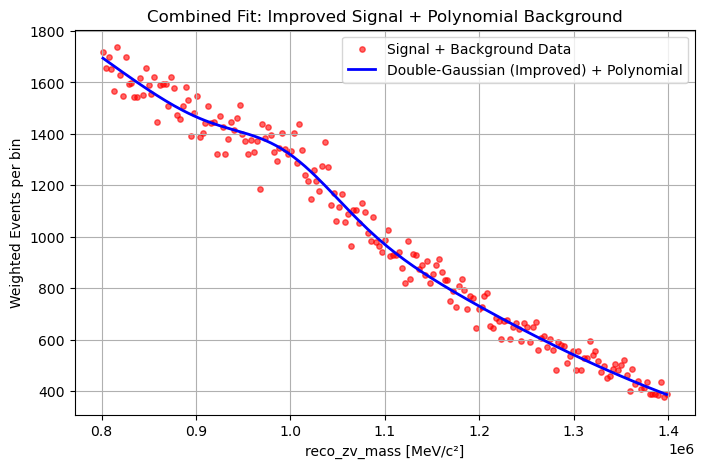

Chi²(H₀): 318.95
Chi²(H₁): 217.04
Δχ²: 101.91
Statistical Significance (Z): 10.09 sigma


In [11]:
# ================================================
# Cell 2: Combined Fit with Improved (Double Gaussian) + Polynomial
# ================================================

def combined_model_improved_fn(centers, mu_fixed, sigma_first, frac_first, sigma_second,
                               sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d):
    """
    Combined model: Improved double-Gaussian signal + polynomial background.
    """
    signal_component = double_gaussian_fn(centers, sig_ampl, mu_fixed, sigma_first, frac_first, sigma_second)
    background_component = poly_model(centers, bkg_ampl, coef_a, coef_b, coef_c, coef_d)
    return signal_component + background_component

def make_chi2_combined_improved_fn(centers, weights_sum, weights_sum_sq, bin_width, mu_fixed):
    """
    Return a chi² function for the improved double-Gaussian (signal) + polynomial (background) model.
    """
    def chi2_combined(sigma_first, frac_first, sigma_second, sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d):
        if not (0 < frac_first < 1):
            return 1e15
        model_prediction = combined_model_improved_fn(centers, mu_fixed,
                                                      sigma_first, frac_first, sigma_second,
                                                      sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d) * bin_width
        return compute_chi2_val(weights_sum, weights_sum_sq, model_prediction)
    return chi2_combined

def fit_combined_improved_model(bin_edges, combined_df, mu_fixed, sigma_eff_fixed,
                                coef_a_init, coef_b_init, coef_c_init, coef_d_init):
    """
    Fit the combined model to the signal-plus-background data.
    """
    total_bins, centers, weights_sum, weights_sum_sq, bin_width = compute_hist_props(bin_edges, combined_df)
    
    chi2_comb_fn = make_chi2_combined_improved_fn(centers, weights_sum, weights_sum_sq, bin_width, mu_fixed)
    
    minuit_comb = Minuit(chi2_comb_fn,
                         sigma_first=0.8 * sigma_eff_fixed,
                         frac_first=0.5,
                         sigma_second=1.2 * sigma_eff_fixed,
                         sig_ampl=1.0,
                         bkg_ampl=1.0,
                         coef_a=coef_a_init,
                         coef_b=coef_b_init,
                         coef_c=coef_c_init,
                         coef_d=coef_d_init)
    
    minuit_comb.limits["sigma_first"] = (0, None)
    minuit_comb.limits["sigma_second"] = (0, None)
    minuit_comb.limits["frac_first"] = (0, 1)
    minuit_comb.limits["sig_ampl"] = (0, None)
    minuit_comb.limits["bkg_ampl"] = (0, None)
    
    minuit_comb.simplex()
    minuit_comb.migrad(ncall=100_000_000)
    
    chi2_improved_model = minuit_comb.fval
    
    model_fit_vals = combined_model_improved_fn(centers, mu_fixed,
                                                minuit_comb.values["sigma_first"],
                                                minuit_comb.values["frac_first"],
                                                minuit_comb.values["sigma_second"],
                                                minuit_comb.values["sig_ampl"],
                                                minuit_comb.values["bkg_ampl"],
                                                minuit_comb.values["coef_a"],
                                                minuit_comb.values["coef_b"],
                                                minuit_comb.values["coef_c"],
                                                minuit_comb.values["coef_d"]) * bin_width

    hist_counts, _ = np.histogram(combined_df['reco_zv_mass'], bins=bin_edges,
                                  weights=combined_df['FullEventWeight'])
    plt.figure(figsize=(8, 5))
    plt.scatter(centers, hist_counts, color='red', alpha=0.6, s=15, label='Signal + Background Data')
    plt.plot(centers, model_fit_vals, 'b-', linewidth=2, label='Double-Gaussian (Improved) + Polynomial')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Weighted Events per bin')
    plt.title('Combined Fit: Improved Signal + Polynomial Background')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return chi2_improved_model

print("=== Combined Fit with Improved Gaussian + Polynomial ===")
H1_chi2_improved = fit_combined_improved_model(
    mass_bins, 
    combined_data_df,
    best_mu_improved,          
    effective_sigma_improved,   
    poly_fit_a, poly_fit_b, poly_fit_c, poly_fit_d  
)

chi2_diff_improved = H0_chi2 - H1_chi2_improved
Z_improved = np.sqrt(chi2_diff_improved)
print("Chi²(H₀): {:.2f}".format(H0_chi2))
print("Chi²(H₁): {:.2f}".format(H1_chi2_improved))
print("Δχ²: {:.2f}".format(chi2_diff_improved))
print("Statistical Significance (Z): {:.2f} sigma".format(Z_improved))




## Neural Network Classification

### 3a – Training the Neural Network

We train a neural network classifier using the following features:

$$
\text{Training features: } \{ \text{lep1\_pt, lep2\_pt, fatjet\_pt, fatjet\_eta, fatjet\_D2, Zll\_mass, Zll\_pt, MET} \}.
$$

A 50%–50% mixture of signal and background events is used for training.

### 3b – Evaluating the Classifier

The classifier is evaluated using standard metrics: accuracy, ROC AUC, and log loss. The ROC curve is plotted in display mode.

### 3c – NN Cleaning

The function `NN_cleaned_sig_plots` uses the trained pipeline to predict on the full cut data (global variable `cut_data`) and selects signal events with a predicted probability of at least 0.5. The cleaned distribution of *reco_zv_mass* is then plotted.


2185/2185 ━━━━━━━━━━━━━━━━━━━━ 2s 825us/step

--- Classifier Evaluation ---
Binary classification accuracy: 0.8113
AUC (ROC): 0.8902
Log Loss: 0.4194


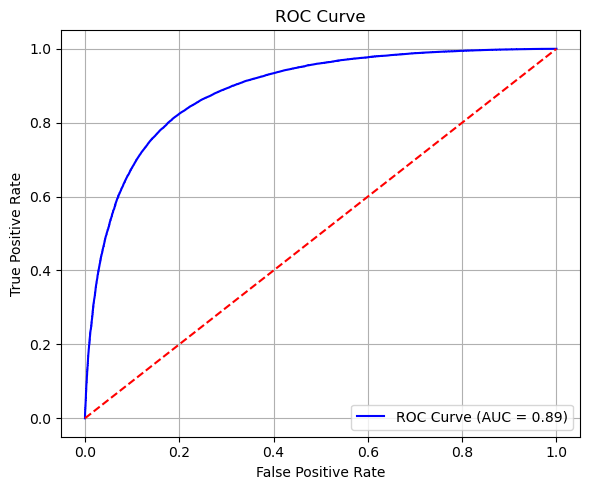

16040/16040 ━━━━━━━━━━━━━━━━━━━━ 13s 819us/step


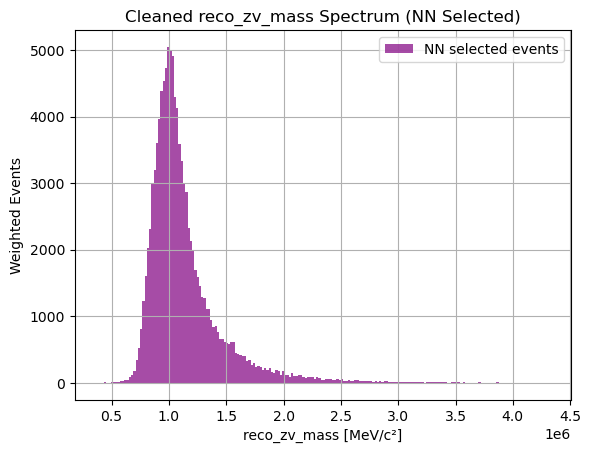

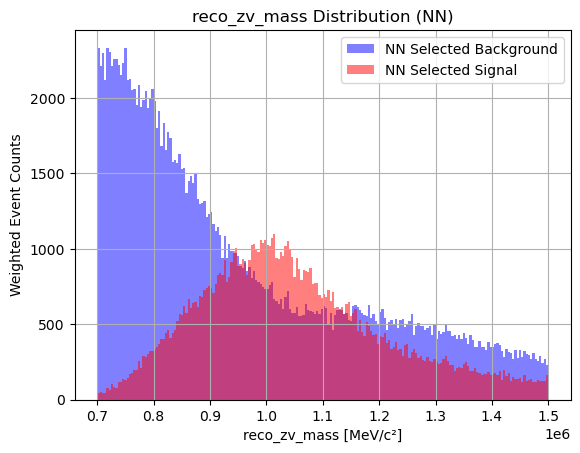

In [14]:
# ============================================================
# Task 3 – Neural Network Classifier (Using Original Feature Set)
# ============================================================

# For NN training, we use the same selection cuts as before.
nn_sig_df = sig_cut_df.copy()
nn_bkg_df = bkg_cut_df.copy()
nn_bkg_df = nn_bkg_df[:len(nn_sig_df)]  # Use 50% background

nn_combined_df = pd.concat([nn_sig_df, nn_bkg_df], ignore_index=True)
nn_train_cols = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET']
nn_num_inputs = len(nn_train_cols)

# Shuffle the dataset with a fixed random state.
nn_combined_df = nn_combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
nn_features = nn_combined_df[nn_train_cols].to_numpy()
nn_labels = nn_combined_df['isSignal'].to_numpy()

# ---------------------------------------------------
# Define the NN model factory.
def create_classification_model_fn(N_inputs):
    def classification_model(X, y):
        num_nodes = N_inputs * 20
        classifier = Sequential()
        classifier.add(Input(shape=(N_inputs,)))
        classifier.add(Dense(num_nodes, kernel_initializer='normal', activation='relu'))
        classifier.add(Dropout(0.1))
        classifier.add(Dense(N_inputs, kernel_initializer='normal', activation='relu'))
        classifier.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return classifier
    return classification_model

nn_classifier_model = create_classification_model_fn(nn_num_inputs)
nn_sklearn_regressor = SKLearnRegressor(model=nn_classifier_model, fit_kwargs={'epochs': 100, 'batch_size': 1000, 'verbose': 0})

nn_pipeline_steps = [('standardize', StandardScaler()), ('mlp', nn_sklearn_regressor)]
nn_classifier_pipeline = Pipeline(nn_pipeline_steps)

# Fit the pipeline.
nn_classifier_pipeline.fit(nn_features, nn_labels.ravel())
nn_predictions = nn_classifier_pipeline.predict(nn_features)

# Evaluate the classifier.
def evaluate_nn_classifier_fn(true_labels, predicted_probs):
    """
    Evaluate classifier performance using accuracy, AUC and log loss.
    """
    predicted_labels = (predicted_probs >= 0.5).astype(int)
    accuracy_val = accuracy_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc_val = auc(fpr, tpr)
    logloss_val = log_loss(true_labels, predicted_probs)
    print("\n--- Classifier Evaluation ---")
    print(f"Binary classification accuracy: {accuracy_val:.4f}")
    print(f"AUC (ROC): {roc_auc_val:.4f}")
    print(f"Log Loss: {logloss_val:.4f}")
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_val:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
evaluate_nn_classifier_fn(nn_labels, nn_predictions)

# ---------------------------------------------------
# Define the NN cleaning function.
def plot_nn_cleaned_signal_fn(columns, pipeline_obj):
    """
    Plots the NN-cleaned signal distribution for the full cut_df.
    Uses the global variable cut_df.
    Returns the NN-selected signal DataFrame and the NN output probabilities.
    """
    cut_input = cut_df[columns].to_numpy()
    nn_output_probs = pipeline_obj.predict(cut_input)
    nn_selected_signal = cut_df[nn_output_probs >= 0.5].copy()
    plt.hist(nn_selected_signal['reco_zv_mass'], bins=n_bins, weights=nn_selected_signal['FullEventWeight'],
             alpha=0.7, label='NN selected events', color='purple')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Weighted Events')
    plt.title('Cleaned reco_zv_mass Spectrum (NN Selected)')
    plt.grid()
    plt.legend()
    plt.show()
    return nn_selected_signal, nn_output_probs

nn_selected_signal, nn_output_probs = plot_nn_cleaned_signal_fn(nn_train_cols, nn_classifier_pipeline)

# ---------------------------------------------------
# Define the function for plotting NN-cleaned signal and background distributions.
def plot_nn_cleaned_sig_bkg_fn(min_mass, max_mass, nn_output_probs, nn_selected_signal):
    """
    Plots the NN-cleaned distribution of signal and background events.
    Returns the NN-selected signal cut, background cut, combined cut DataFrames and bin edges.
    """
    nn_selected_bkg = cut_df[nn_output_probs < 0.5].copy()
    signal_range_str = f"reco_zv_mass < {max_mass} and reco_zv_mass > {min_mass}"
    nn_signal_cut = nn_selected_signal.query(signal_range_str)
    nn_bkg_cut = nn_selected_bkg.query(signal_range_str)
    nn_combined_cut = cut_df.query(signal_range_str)
    bins_nn = np.linspace(min_mass_nn, max_mass_nn, n_bins)
    plt.hist(nn_bkg_cut['reco_zv_mass'], bins=n_bins, histtype='stepfilled', alpha=0.5,
             weights=nn_bkg_cut['FullEventWeight'], color='blue', label='NN Selected Background')
    plt.hist(nn_signal_cut['reco_zv_mass'], bins=n_bins, histtype='stepfilled', alpha=0.5,
             weights=nn_signal_cut['FullEventWeight'], color='red', label='NN Selected Signal')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Weighted Event Counts')
    plt.title('reco_zv_mass Distribution (NN)')
    plt.legend()
    plt.grid()
    plt.show()
    return nn_signal_cut, nn_bkg_cut, nn_combined_cut, bins_nn

min_mass_nn = 0.7e6
max_mass_nn = 1.5e6
nn_signal_cut, nn_bkg_cut, nn_combined_cut, bins_nn = plot_nn_cleaned_sig_bkg_fn(min_mass_nn, max_mass_nn, nn_output_probs, nn_selected_signal)



=== Step 1: Signal-Only Gaussian Fit on NN-Cleaned Signal ===
Best-fit mean: 1,035,764.5 MeV/c²
Best-fit sigma: 160,847.6 MeV


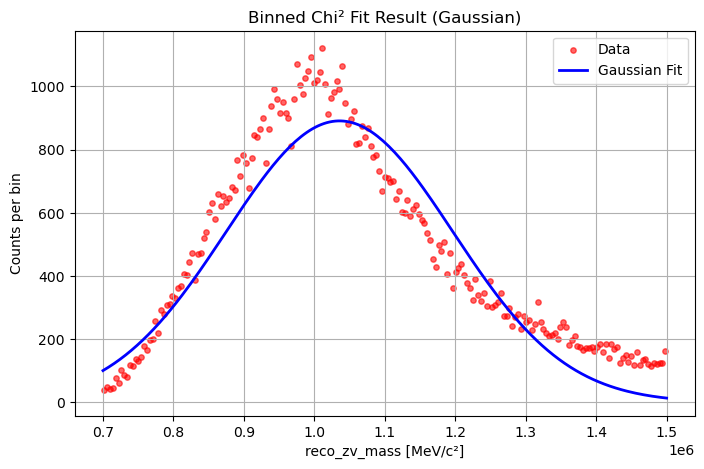


=== Step 2: Polynomial-Only Fit (H₀) on the NN-Cleaned Combined Data ===


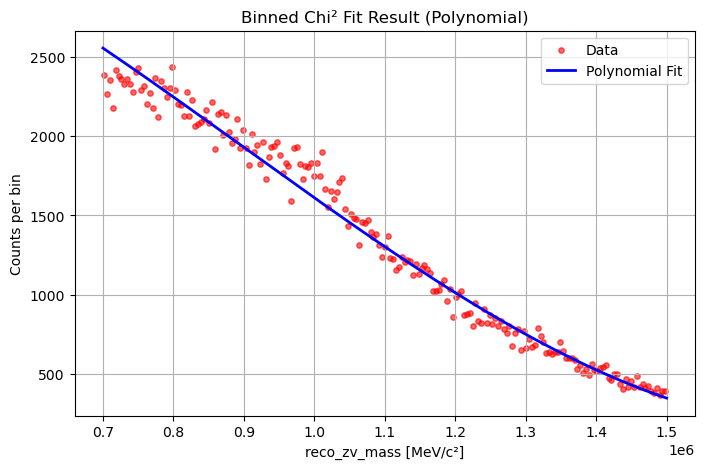


=== Step 3: Combined Gaussian + Polynomial Fit (H₁) ===


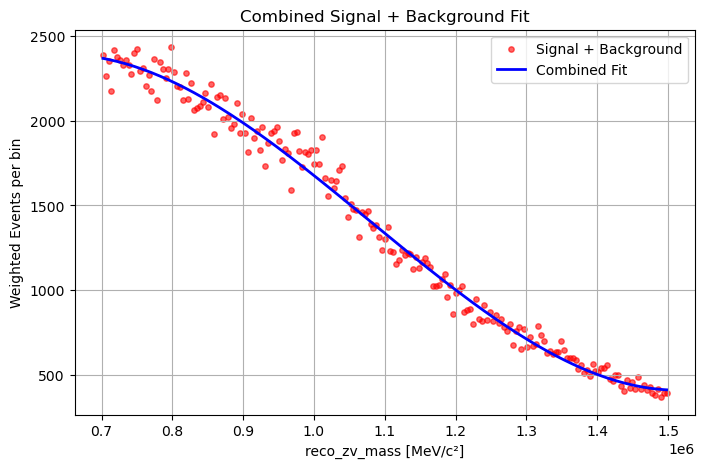


=== Step 4: Compute Δχ² and Statistical Significance ===
Chi²(H₀): 479.73
Chi²(H₁): 309.35
Δχ²: 170.38
Statistical Significance (Z): 13.05 sigma


In [17]:
# ============================================================
# Task 3c – Two-Fit Procedure (H0 vs. H1) on NN-Cleaned Data
# ============================================================

print("=== Step 1: Signal-Only Gaussian Fit on NN-Cleaned Signal ===")

# 1) Isolate the NN-selected signal data in the relevant mass window:
nn_fit_range_str = f"reco_zv_mass > {min_mass_nn} and reco_zv_mass < {max_mass_nn}"
nn_signal_subset = nn_signal_cut.query(nn_fit_range_str)

# 2) Perform the Gaussian fit on these NN-selected events:
mu_fixed_nn, sigma_fixed_nn = fit_gauss_model(bins_nn, nn_signal_subset)

print("\n=== Step 2: Polynomial-Only Fit (H₀) on the NN-Cleaned Combined Data ===")

# 3) Fit a polynomial to the combined signal+background distribution within the same mass window:
H0_chi2_nn, poly_coef_a_nn, poly_coef_b_nn, poly_coef_c_nn, poly_coef_d_nn = fit_poly_model(bins_nn, nn_combined_cut)

print("\n=== Step 3: Combined Gaussian + Polynomial Fit (H₁) ===")

# 4) Superimpose a Gaussian (using mu_fixed_nn, sigma_fixed_nn from Step 1) onto the polynomial,
#    re-floating only the normalizations of signal & background:
H1_chi2_nn = fit_combined_model(bins_nn, nn_combined_cut,
                                poly_coef_a_nn, poly_coef_b_nn, poly_coef_c_nn, poly_coef_d_nn,
                                mu_fixed_nn, sigma_fixed_nn)

print("\n=== Step 4: Compute Δχ² and Statistical Significance ===")

# 5) Wilks's theorem => difference in χ²:
chi2_diff_nn = H0_chi2_nn - H1_chi2_nn
Z_nn = np.sqrt(chi2_diff_nn)

print(f"Chi²(H₀): {H0_chi2_nn:.2f}")
print(f"Chi²(H₁): {H1_chi2_nn:.2f}")
print(f"Δχ²: {chi2_diff_nn:.2f}")
print(f"Statistical Significance (Z): {Z_nn:.2f} sigma")




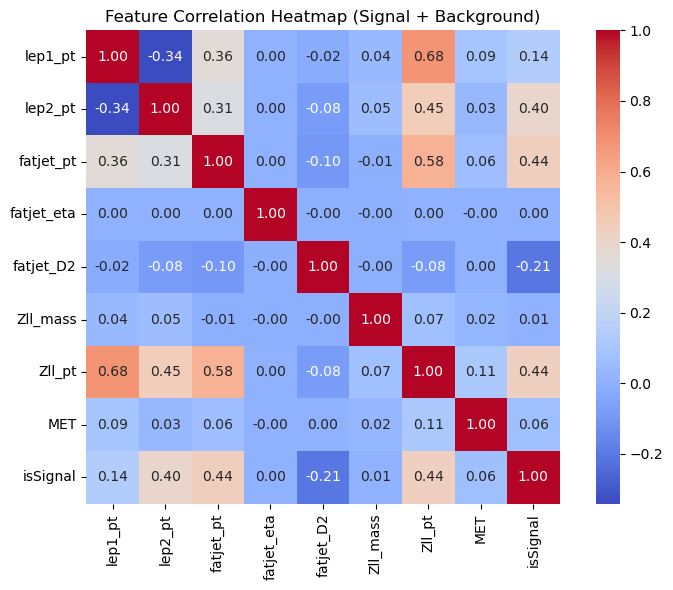

656/656 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step

--- Improved Classifier Evaluation ---
Accuracy: 0.8072
AUC (ROC): 0.8841
Log Loss: 0.4310


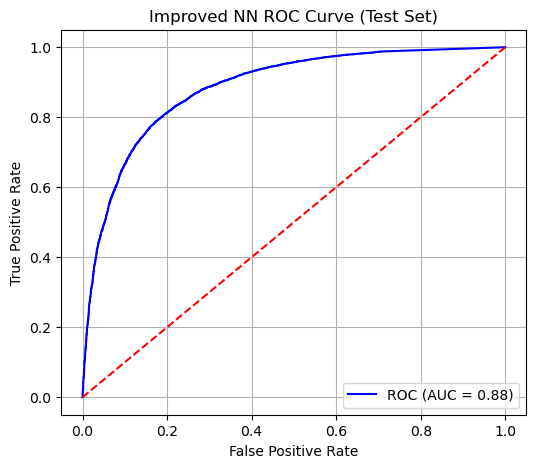


--- Applying Improved Model to Full cut_df ---
16040/16040 ━━━━━━━━━━━━━━━━━━━━ 14s 855us/step


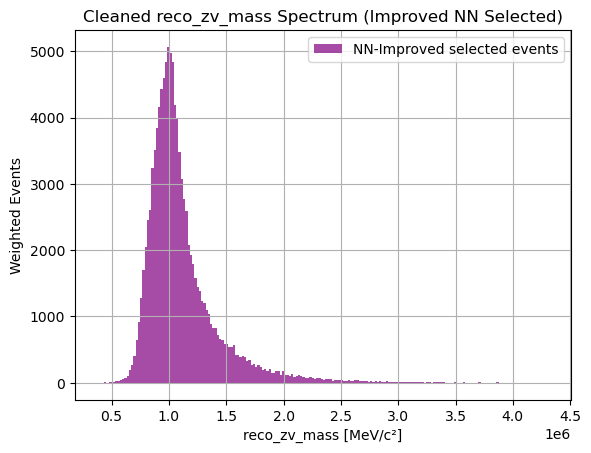

In [19]:
# ============================================================
# Task 3 – Improved Neural Network Classifier with Seaborn Heatmaps
# ============================================================

import seaborn as sns
from sklearn.model_selection import train_test_split

##############################################
# 1. Visualize the Correlations via Heatmap
##############################################
# Use the NN feature columns from the original code:
nn_train_cols = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta',
                 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET']

# (A) Create a labeled DataFrame for correlation analysis using nn_combined_df.
nn_corr_df = nn_combined_df[nn_train_cols + ['isSignal']].copy()

# (B) Compute the correlation matrix.
nn_corr_matrix = nn_corr_df.corr()

# (C) Plot correlation heatmap with seaborn.
plt.figure(figsize=(8,6))
sns.heatmap(nn_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap (Signal + Background)")
plt.tight_layout()
plt.show()

##############################################
# 2. Improved Train/Test Split
##############################################
# Perform a 70/30 train/test split to reduce overfitting.
nn_X_full = nn_combined_df[nn_train_cols].to_numpy()
nn_y_full = nn_combined_df['isSignal'].to_numpy()

nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(
    nn_X_full, nn_y_full, test_size=0.3, random_state=42
)

##############################################
# 3. Define an Updated Classification Model
##############################################
def create_improved_classifier_model_fn(N_inputs):
    def classifier_model(X, y):
        num_units = N_inputs * 24
        model = Sequential()
        model.add(Input(shape=(N_inputs,)))
        model.add(Dense(num_units, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.15))
        model.add(Dense(num_units // 2, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.1))
        model.add(Dense(N_inputs, activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    return classifier_model

nn_num_inputs = len(nn_train_cols)
improved_nn_model = create_improved_classifier_model_fn(nn_num_inputs)
nn_regressor_improved = SKLearnRegressor(
    model=improved_nn_model,
    fit_kwargs={'epochs': 100, 'batch_size': 1000, 'verbose': 0}
)

nn_pipeline_steps_improved = [('standardize', StandardScaler()), ('mlp', nn_regressor_improved)]
nn_improved_pipeline = Pipeline(nn_pipeline_steps_improved)

##############################################
# 4. Fit the Improved Pipeline
##############################################
nn_improved_pipeline.fit(nn_X_train, nn_y_train.ravel())
nn_test_predictions = nn_improved_pipeline.predict(nn_X_test)

##############################################
# 5. Evaluate the Improved Classifier
##############################################
def evaluate_improved_classifier_fn(true_labels, predicted_probs):
    """
    Evaluate classifier performance using accuracy, AUC and log loss (test set).
    """
    predicted_labels = (predicted_probs >= 0.5).astype(int)
    accuracy_val = accuracy_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc_val = auc(fpr, tpr)
    logloss_val = log_loss(true_labels, predicted_probs)
    
    print("\n--- Improved Classifier Evaluation ---")
    print(f"Accuracy: {accuracy_val:.4f}")
    print(f"AUC (ROC): {roc_auc_val:.4f}")
    print(f"Log Loss: {logloss_val:.4f}")
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Improved NN ROC Curve (Test Set)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

evaluate_improved_classifier_fn(nn_y_test, nn_test_predictions)

##############################################
# 6. Demonstrate NN-Cleaned (Full Data) Distributions
##############################################
# Apply the improved pipeline to the entire cut_df.
print("\n--- Applying Improved Model to Full cut_df ---")
nn_cut_input = cut_df[nn_train_cols].to_numpy()
nn_full_probs = nn_improved_pipeline.predict(nn_cut_input)

nn_selected_signal_df = cut_df[nn_full_probs >= 0.5].copy()

plt.hist(nn_selected_signal_df['reco_zv_mass'], 
         bins=n_bins, 
         weights=nn_selected_signal_df['FullEventWeight'],
         alpha=0.7, color='purple', label='NN-Improved selected events')
plt.xlabel('reco_zv_mass [MeV/c²]')
plt.ylabel('Weighted Events')
plt.title('Cleaned reco_zv_mass Spectrum (Improved NN Selected)')
plt.grid()
plt.legend()
plt.show()




=== H₀: Polynomial-Only Fit on NN-Selected Data ===


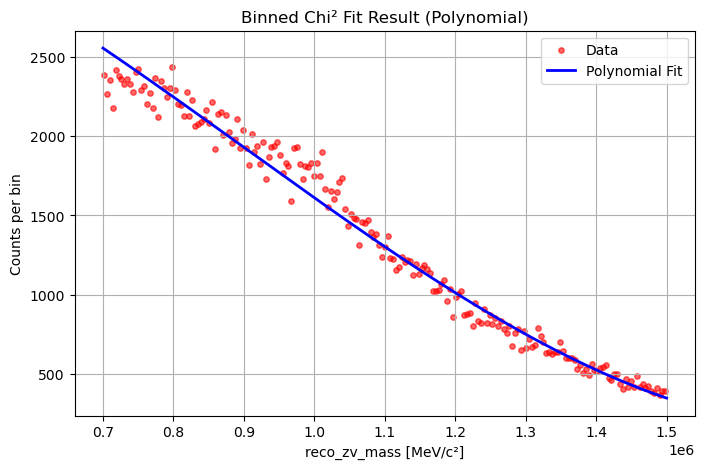


=== H₁: Double-Gaussian + Polynomial Fit on NN-Filtered Data ===


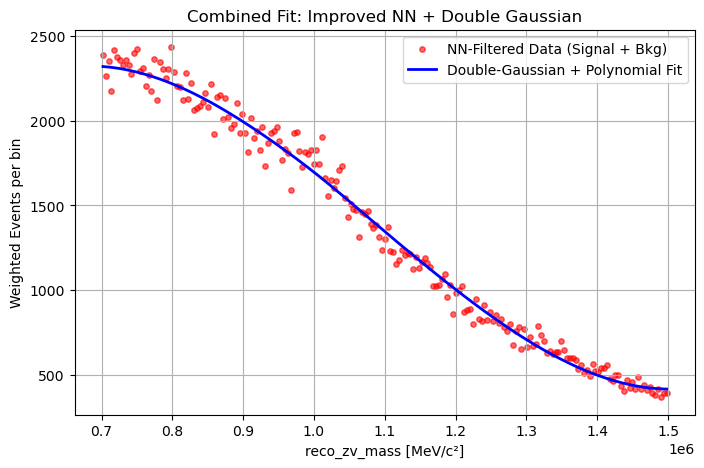


--- Final Significance from Improved NN + Double-Gaussian Fit ---
Chi²(H₀): 479.70
Chi²(H₁): 312.76
Δχ²: 166.94
Statistical Significance (Z): 12.92 sigma


In [20]:
# ================================================
# Task 3 – Improved NN + Double-Gaussian Fit on NN-Cleaned Data
# ================================================

##############################################
# 1. Separate the NN-Cleaned Signal and Background
##############################################
nn_selected_improved_df = cut_df[nn_full_probs >= 0.5].copy()   # "signal-like"
nn_nonselected_improved_df = cut_df[nn_full_probs < 0.5].copy()  # "background-like"

nn_combined_improved_df = pd.concat([nn_selected_improved_df, nn_nonselected_improved_df], ignore_index=True)

##############################################
# 2. Fit Polynomial-Only (H₀)
##############################################
print("=== H₀: Polynomial-Only Fit on NN-Selected Data ===")
H0_chi2_improved, poly_coef_a_improved, poly_coef_b_improved, poly_coef_c_improved, poly_coef_d_improved = fit_poly_model(bins_nn, nn_combined_improved_df)

##############################################
# 3. Double-Gaussian + Polynomial (H₁)
##############################################
def combined_model_dg_free_mu(centers, mu_free, sigma_first, frac_first, sigma_second,
                              sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d):
    """
    Double-Gaussian (signal) with free mu + polynomial (background).
    """
    signal_part = double_gaussian_fn(centers, sig_ampl, mu_free, sigma_first, frac_first, sigma_second)
    background_part = poly_model(centers, bkg_ampl, coef_a, coef_b, coef_c, coef_d)
    return signal_part + background_part

def make_chi2_dg_free_mu_fn(centers, weights_sum, weights_sum_sq, bin_width):
    """
    Return a chi² function for the double-Gaussian + polynomial model with free mu.
    """
    def chi2_total(mu_free, sigma_first, frac_first, sigma_second, sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d):
        if not (0 < frac_first < 1):
            return 1e15
        model_vals = combined_model_dg_free_mu(centers, mu_free, sigma_first, frac_first, sigma_second,
                                               sig_ampl, bkg_ampl, coef_a, coef_b, coef_c, coef_d) * bin_width
        return compute_chi2_val(weights_sum, weights_sum_sq, model_vals)
    return chi2_total

def fit_combined_dg_free_mu_model(bin_edges, combined_df, coef_a_init, coef_b_init, coef_c_init, coef_d_init):
    """
    Fit the double-Gaussian + polynomial model with free mu on NN-cleaned data.
    Returns the minimized chi² value (H₁) and the Minuit object.
    """
    total_bins, centers, weights_sum, weights_sum_sq, bin_width = compute_hist_props(bin_edges, combined_df)
    chi2_fn = make_chi2_dg_free_mu_fn(centers, weights_sum, weights_sum_sq, bin_width)
    
    minuit_obj = Minuit(chi2_fn,
                        mu_free=1.0e6,
                        sigma_first=5.0e4,
                        frac_first=0.5,
                        sigma_second=7.0e4,
                        sig_ampl=1.0,
                        bkg_ampl=1.0,
                        coef_a=coef_a_init,
                        coef_b=coef_b_init,
                        coef_c=coef_c_init,
                        coef_d=coef_d_init)
    
    minuit_obj.limits["mu_free"] = (0, None)
    minuit_obj.limits["sigma_first"] = (1, None)
    minuit_obj.limits["sigma_second"] = (1, None)
    minuit_obj.limits["frac_first"] = (0, 1)
    minuit_obj.limits["sig_ampl"] = (0, None)
    minuit_obj.limits["bkg_ampl"] = (0, None)
    
    minuit_obj.simplex()
    minuit_obj.migrad(ncall=100_000_000)
    
    H1_chi2_value = minuit_obj.fval
    
    # Plot the final combined fit.
    model_prediction = combined_model_dg_free_mu(centers,
                                                 minuit_obj.values["mu_free"],
                                                 minuit_obj.values["sigma_first"],
                                                 minuit_obj.values["frac_first"],
                                                 minuit_obj.values["sigma_second"],
                                                 minuit_obj.values["sig_ampl"],
                                                 minuit_obj.values["bkg_ampl"],
                                                 minuit_obj.values["coef_a"],
                                                 minuit_obj.values["coef_b"],
                                                 minuit_obj.values["coef_c"],
                                                 minuit_obj.values["coef_d"]) * bin_width

    hist_counts, _ = np.histogram(combined_df['reco_zv_mass'], bins=bin_edges, weights=combined_df['FullEventWeight'])
    
    plt.figure(figsize=(8, 5))
    plt.scatter(centers, hist_counts, color='red', alpha=0.6, s=15, label='NN-Filtered Data (Signal + Bkg)')
    plt.plot(centers, model_prediction, 'b-', linewidth=2, label='Double-Gaussian + Polynomial Fit')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Weighted Events per bin')
    plt.title('Combined Fit: Improved NN + Double Gaussian')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return H1_chi2_value, minuit_obj

print("\n=== H₁: Double-Gaussian + Polynomial Fit on NN-Filtered Data ===")
H1_chi2_improvedDG, minuit_fitter = fit_combined_dg_free_mu_model(
    bins_nn, nn_combined_improved_df,
    poly_coef_a_improved, poly_coef_b_improved, poly_coef_c_improved, poly_coef_d_improved
)

##############################################
# 4. Compute Δχ² and Significance
##############################################
chi2_diff_NN = H0_chi2_improved - H1_chi2_improvedDG
Z_NN = np.sqrt(chi2_diff_NN)
print("\n--- Final Significance from Improved NN + Double-Gaussian Fit ---")
print(f"Chi²(H₀): {H0_chi2_improved:.2f}")
print(f"Chi²(H₁): {H1_chi2_improvedDG:.2f}")
print(f"Δχ²: {chi2_diff_NN:.2f}")
print(f"Statistical Significance (Z): {Z_NN:.2f} sigma")




## Impact of Training Sample on the Classifier

### 4a – New NN Classifier with Additional Feature

We now include *reco_zv_mass* as an input feature:
$$
\text{New Training Features: } \{ \text{lep1\_pt, lep2\_pt, fatjet\_pt, fatjet\_eta, fatjet\_D2, Zll\_mass, Zll\_pt, MET, reco\_zv\_mass} \}.
$$

The new classifier is trained on the same 50%-50% mixture and then evaluated.

### 4b – Application and NN Cleaning

The new classifier is applied to the full cut_data (with the new features) to obtain NN predictions and select signal events (probability \(\geq 0.5\)). The cleaned distributions for signal and background are then plotted over a mass range:
$$
0.7 \times 10^6 \leq \text{reco\_zv\_mass} \leq 1.5 \times 10^6.
$$

### 4c – Combined Model Fitting on NN-Cleaned Data

For the NN-cleaned data, we fit the signal with a Gaussian (fixing the mean and sigma) and the combined data with a sum of the Gaussian and a cubic polynomial. The difference in chi² values between the null hypothesis (polynomial only) and the alternative hypothesis (combined model) is used to compute the statistical significance:
$$
Z = \sqrt{\chi^2(H_0) - \chi^2(H_1)}.
$$

The final outputs, including the fitted parameters and the statistical significance, are printed.


2185/2185 ━━━━━━━━━━━━━━━━━━━━ 2s 864us/step

--- Improved Classifier Evaluation ---
Accuracy: 0.9086
AUC (ROC): 0.9669
Log Loss: 0.2271


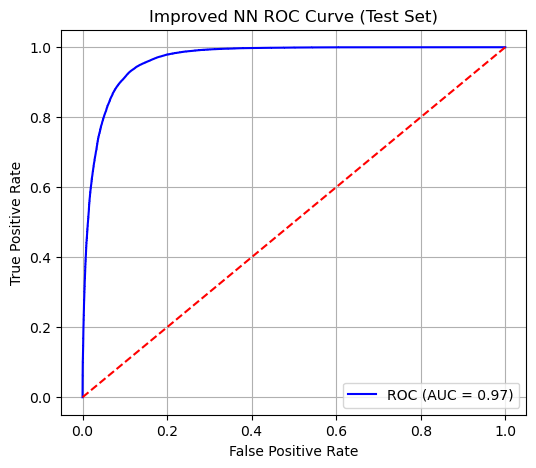

16040/16040 ━━━━━━━━━━━━━━━━━━━━ 13s 829us/step
16040/16040 ━━━━━━━━━━━━━━━━━━━━ 13s 837us/step


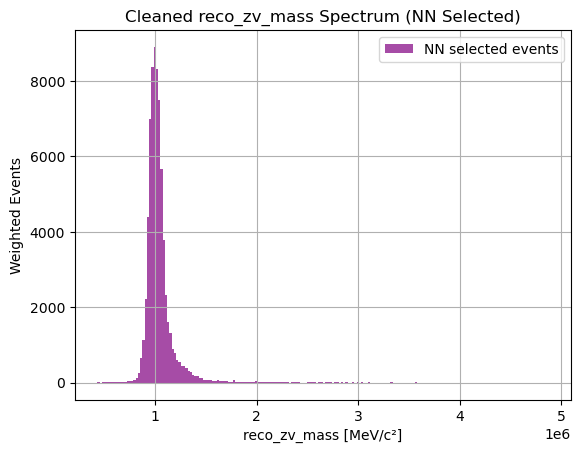

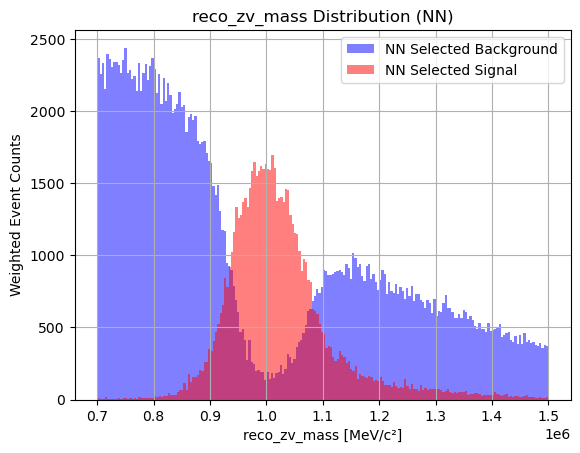

--- Gaussian Fit on NN Signal Data Only (New) ---
Best-fit mean: 1,007,099.5 MeV/c²
Best-fit sigma: 64,682.7 MeV


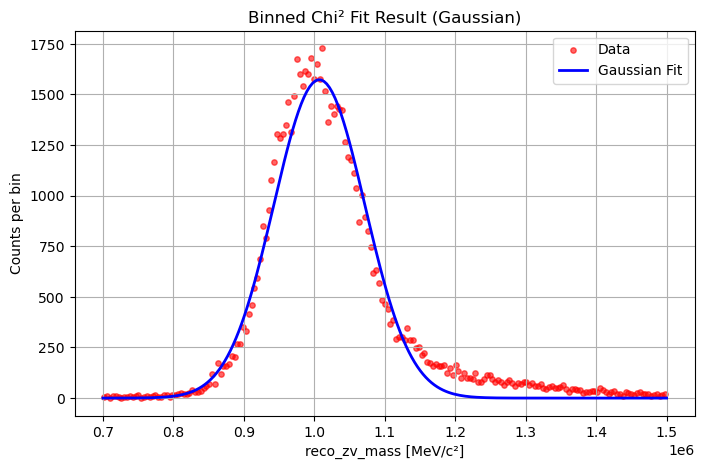

--- Polynomial Fit on NN Signal + Background Data (New) ---


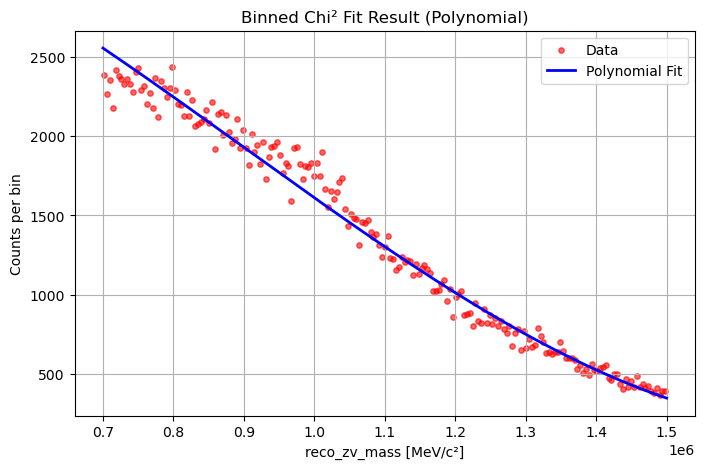

--- Combined Gaussian + Polynomial Fit on NN Data (New) ---


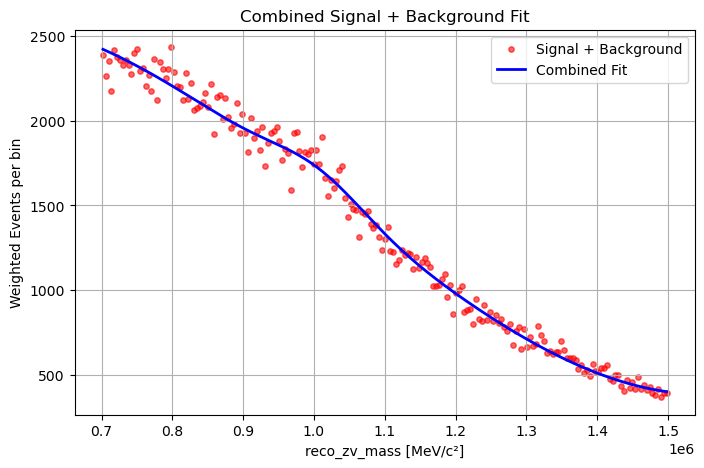

Chi² (H₀, new): 479.73
Chi² (H₁, new): 268.08
Δχ² (new): 211.65
Statistical Significance (Z, new): 14.55 sigma


In [22]:
# ================================================
# Task 4 – Impact of Training Sample on Classifier
# ================================================

# 4a: Redefine training columns to include 'reco_zv_mass'
nn_train_cols_incl = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass']
nn_num_inputs_incl = len(nn_train_cols_incl)
nn_features_incl = nn_combined_df[nn_train_cols_incl].to_numpy()
nn_labels_full = nn_combined_df['isSignal'].to_numpy()

# 4b: Build the new model using the updated classifier factory.
improved_incl_model = create_improved_classifier_model_fn(nn_num_inputs_incl)
nn_regressor_incl = SKLearnRegressor(model=improved_incl_model, fit_kwargs={'epochs': 100, 'batch_size': 1000, 'verbose': 0})
estimators_incl = [('standardize', StandardScaler()), ('mlp', nn_regressor_incl)]
pipeline_2 = Pipeline(estimators_incl)
pipeline_2.fit(nn_features_incl, nn_labels_full.ravel())
model_y_2 = pipeline_2.predict(nn_features_incl)
evaluate_improved_classifier_fn(nn_labels_full, model_y_2)

# 4c: Apply the New NN Classifier to the full cut_df and plot cleaned distributions.
cut_df_input_2 = cut_df[nn_train_cols_incl].to_numpy()
full_probs_2 = pipeline_2.predict(cut_df_input_2)

nn_selected_sig_2, _ = plot_nn_cleaned_signal_fn(nn_train_cols_incl, pipeline_2)
nn_sig_cut_2, nn_bkg_cut_2, nn_combined_cut_2, bins_nn_2 = plot_nn_cleaned_sig_bkg_fn(min_mass_nn, max_mass_nn, full_probs_2, nn_selected_sig_2)

# 4d: Fit the NN-cleaned data with the combined model.
print("--- Gaussian Fit on NN Signal Data Only (New) ---")
nn_fit_range_str = f"reco_zv_mass > {min_mass_nn} and reco_zv_mass < {max_mass_nn}"
mu_fixed_nn_2, sigma_fixed_nn_2 = fit_gauss_model(bins_nn_2, nn_sig_cut_2.query(nn_fit_range_str))

print("--- Polynomial Fit on NN Signal + Background Data (New) ---")
H0_chi2_nn_2, poly_coef_a_nn_2, poly_coef_b_nn_2, poly_coef_c_nn_2, poly_coef_d_nn_2 = fit_poly_model(bins_nn_2, nn_combined_cut_2)

print("--- Combined Gaussian + Polynomial Fit on NN Data (New) ---")
H1_chi2_nn_2 = fit_combined_model(bins_nn_2, nn_combined_cut_2,
                                  poly_coef_a_nn_2, poly_coef_b_nn_2, poly_coef_c_nn_2, poly_coef_d_nn_2,
                                  mu_fixed_nn_2, sigma_fixed_nn_2)

chi2_diff_nn_2 = H0_chi2_nn_2 - H1_chi2_nn_2
Z_nn_2 = np.sqrt(chi2_diff_nn_2)
print("Chi² (H₀, new): {:.2f}".format(H0_chi2_nn_2))
print("Chi² (H₁, new): {:.2f}".format(H1_chi2_nn_2))
print("Δχ² (new): {:.2f}".format(chi2_diff_nn_2))
print("Statistical Significance (Z, new): {:.2f} sigma".format(Z_nn_2))



=== H₀: Polynomial-Only Fit on NN-Selected Data ===


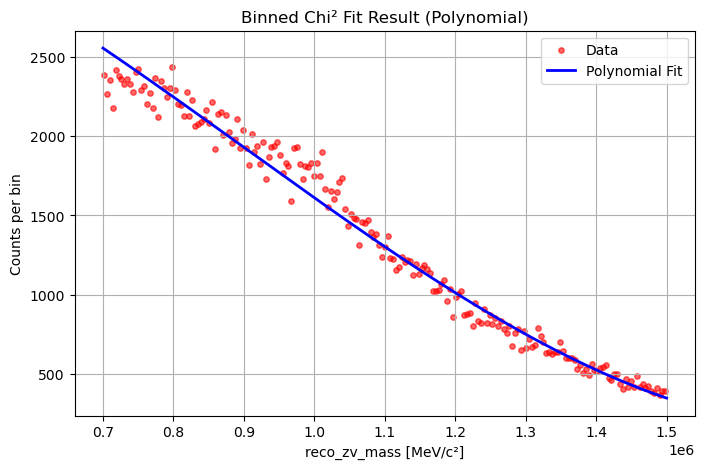


=== H₁: Double-Gaussian + Polynomial Fit on NN-Filtered Data ===


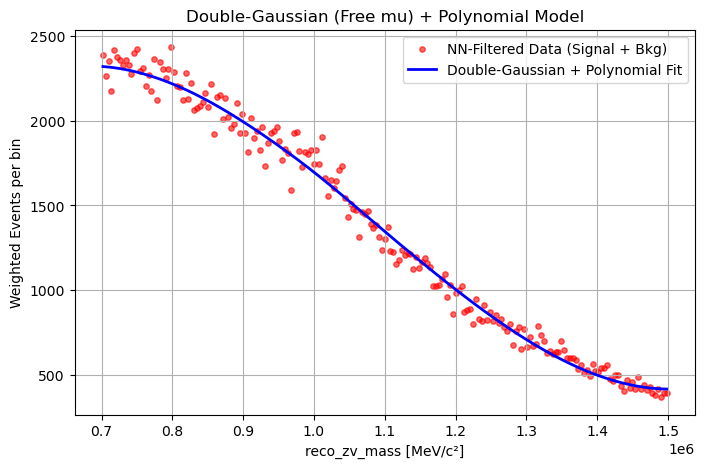


--- Final Significance from Improved NN + Double-Gaussian Fit ---
Chi²(H₀): 479.70
Chi²(H₁): 312.76
Δχ²: 166.94
Statistical Significance (Z): 12.92 sigma
2185/2185 ━━━━━━━━━━━━━━━━━━━━ 2s 851us/step

--- Improved Classifier Evaluation ---
Accuracy: 0.9075
AUC (ROC): 0.9659
Log Loss: 0.2296


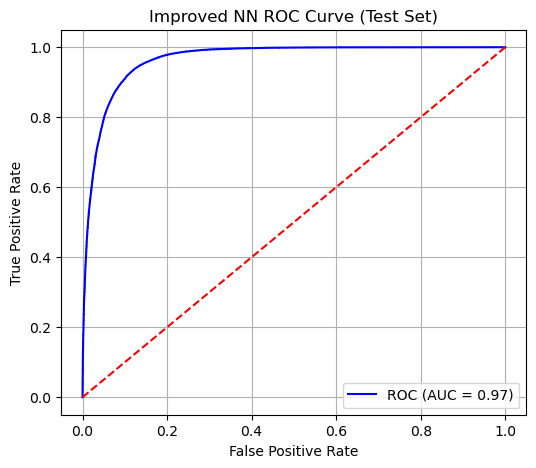

16040/16040 ━━━━━━━━━━━━━━━━━━━━ 13s 830us/step
16040/16040 ━━━━━━━━━━━━━━━━━━━━ 13s 826us/step


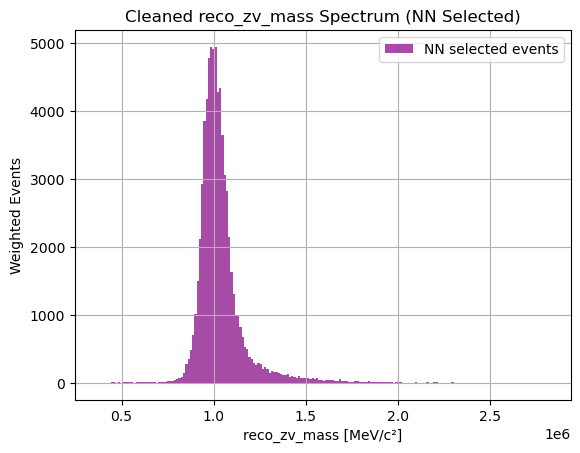

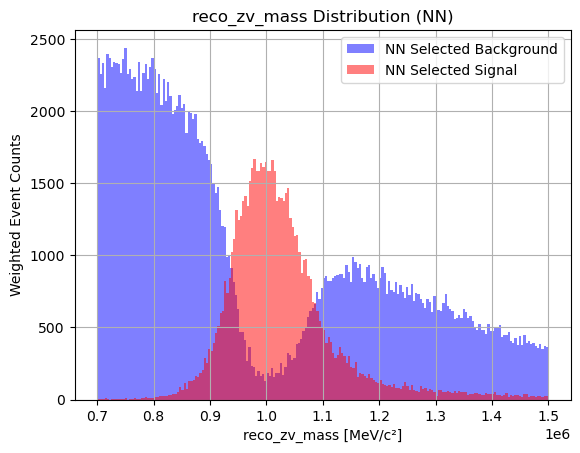

--- Gaussian Fit on NN Signal Data Only (New) ---
Best-fit mean: 1,006,102.3 MeV/c²
Best-fit sigma: 51,577.8 MeV


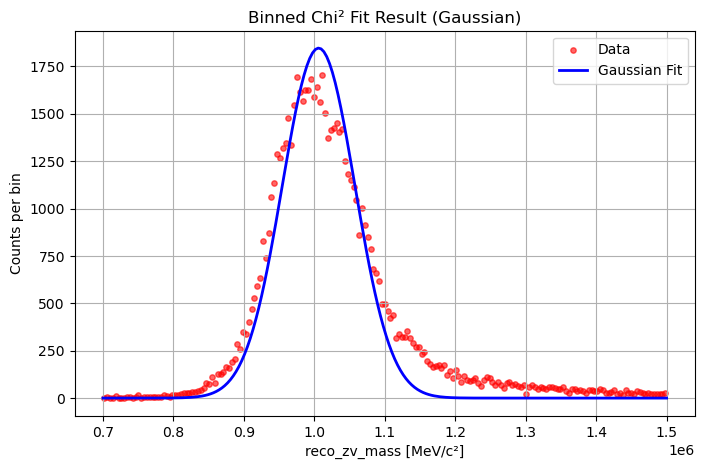

--- Polynomial Fit on NN Signal + Background Data (New) ---


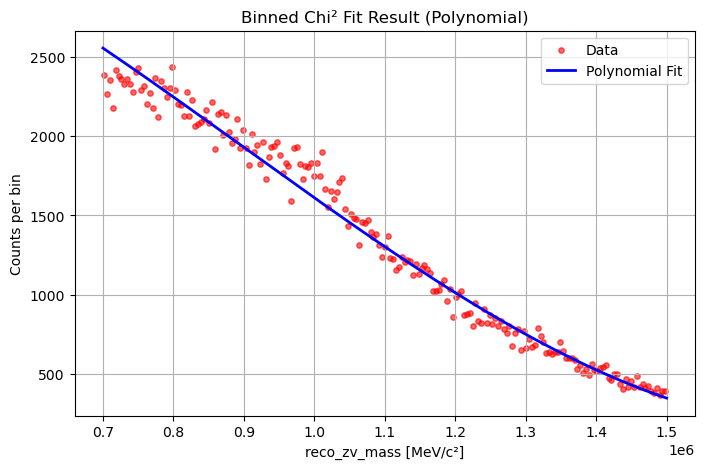

--- Combined Gaussian + Polynomial Fit on NN Data (New) ---


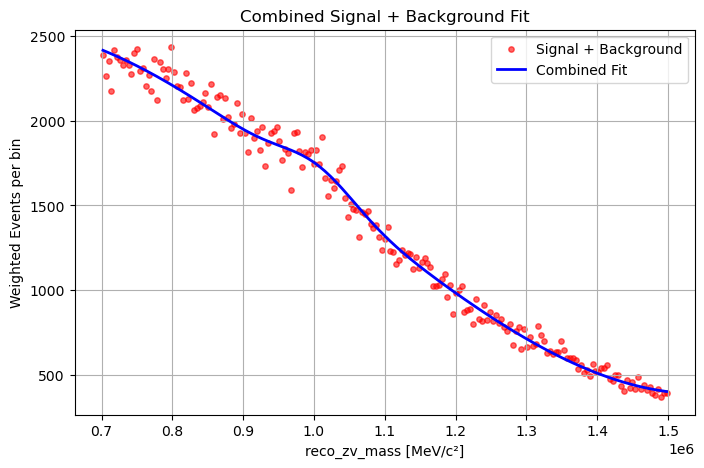

Chi² (H₀, new): 479.73
Chi² (H₁, new): 261.87
Δχ² (new): 217.86
Statistical Significance (Z, new): 14.76 sigma


In [23]:
# ================================================
# Task 4 – Full Improved NN + Double-Gaussian Approach
# ================================================

# Part A: NN-Cleaned Data Combined Fit with Double-Gaussian + Polynomial

# 1. Separate the NN-cleaned signal and background from cut_df using nn_full_probs
nn_sel_improved_df = cut_df[nn_full_probs >= 0.5].copy()   # Signal-like events
nn_non_sel_improved_df = cut_df[nn_full_probs < 0.5].copy()  # Background-like events
nn_combined_improved_df = pd.concat([nn_sel_improved_df, nn_non_sel_improved_df], ignore_index=True)

# 2. Fit Polynomial-Only (H₀) on the NN-cleaned combined data.
print("=== H₀: Polynomial-Only Fit on NN-Selected Data ===")
H0_chi2_improved, poly_coef_a_improved, poly_coef_b_improved, poly_coef_c_improved, poly_coef_d_improved = fit_poly_model(bins_nn, nn_combined_improved_df)

# 3. Fit Combined Gaussian + Polynomial (H₁) using the improved double-Gaussian model with free mu.
def combined_model_dg_free_mu(centers, mu_free, sigma_first, frac_first, sigma_second,
                              sig_norm, bkg_norm, coef_a, coef_b, coef_c, coef_d):
    """
    Combined model: Double-Gaussian (signal) with free mu + polynomial (background).
    """
    sig_component = double_gaussian_fn(centers, sig_norm, mu_free, sigma_first, frac_first, sigma_second)
    bkg_component = poly_model(centers, bkg_norm, coef_a, coef_b, coef_c, coef_d)
    return sig_component + bkg_component

def make_chi2_dg_free_mu_fn(centers, weights_sum, weights_sum_sq, bin_width):
    """
    Return a chi² function for the double-Gaussian + polynomial model with free mu.
    """
    def chi2_total(mu_free, sigma_first, frac_first, sigma_second, sig_norm, bkg_norm, coef_a, coef_b, coef_c, coef_d):
        if not (0 < frac_first < 1):
            return 1e15
        model_vals = combined_model_dg_free_mu(centers, mu_free, sigma_first, frac_first, sigma_second,
                                               sig_norm, bkg_norm, coef_a, coef_b, coef_c, coef_d) * bin_width
        return compute_chi2_val(weights_sum, weights_sum_sq, model_vals)
    return chi2_total

def fit_combined_dg_model(bin_edges, data_df, init_a, init_b, init_c, init_d):
    """
    Fit the double-Gaussian (with free mu) + polynomial model to the NN-cleaned data.
    Returns:
      - H1_chi2: minimized chi² value for the combined fit (H₁)
      - minuit_obj: the Minuit fitter object containing best-fit parameters.
    """
    total_bins, centers, weights_sum, weights_sum_sq, bin_width = compute_hist_props(bin_edges, data_df)
    chi2_fn = make_chi2_dg_free_mu_fn(centers, weights_sum, weights_sum_sq, bin_width)
    
    minuit_obj = Minuit(chi2_fn,
                        mu_free=1.0e6,
                        sigma_first=5.0e4,
                        frac_first=0.5,
                        sigma_second=7.0e4,
                        sig_norm=1.0,
                        bkg_norm=1.0,
                        coef_a=init_a,
                        coef_b=init_b,
                        coef_c=init_c,
                        coef_d=init_d)
    
    minuit_obj.limits["mu_free"] = (0, None)
    minuit_obj.limits["sigma_first"] = (1, None)
    minuit_obj.limits["sigma_second"] = (1, None)
    minuit_obj.limits["frac_first"] = (0, 1)
    minuit_obj.limits["sig_norm"] = (0, None)
    minuit_obj.limits["bkg_norm"] = (0, None)
    
    minuit_obj.simplex()
    minuit_obj.migrad(ncall=100_000_000)
    
    H1_chi2 = minuit_obj.fval
    
    # Plot the final combined fit.
    bin_centers_plot = (bin_edges[:-1] + bin_edges[1:]) / 2
    model_prediction = combined_model_dg_free_mu(bin_centers_plot,
                                                 minuit_obj.values["mu_free"],
                                                 minuit_obj.values["sigma_first"],
                                                 minuit_obj.values["frac_first"],
                                                 minuit_obj.values["sigma_second"],
                                                 minuit_obj.values["sig_norm"],
                                                 minuit_obj.values["bkg_norm"],
                                                 minuit_obj.values["coef_a"],
                                                 minuit_obj.values["coef_b"],
                                                 minuit_obj.values["coef_c"],
                                                 minuit_obj.values["coef_d"]) * (bin_edges[1]-bin_edges[0])
    
    counts, _ = np.histogram(data_df['reco_zv_mass'], bins=bin_edges, weights=data_df['FullEventWeight'])
    plt.figure(figsize=(8,5))
    plt.scatter(bin_centers_plot, counts, color='red', alpha=0.6, s=15, label='NN-Filtered Data (Signal + Bkg)')
    plt.plot(bin_centers_plot, model_prediction, 'b-', lw=2, label='Double-Gaussian + Polynomial Fit')
    plt.xlabel('reco_zv_mass [MeV/c²]')
    plt.ylabel('Weighted Events per bin')
    plt.title('Double-Gaussian (Free mu) + Polynomial Model')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return H1_chi2, minuit_obj

print("\n=== H₁: Double-Gaussian + Polynomial Fit on NN-Filtered Data ===")
H1_chi2_improvedDG, minuit_fitter = fit_combined_dg_model(bins_nn, nn_combined_improved_df,
                                                          poly_coef_a_improved, poly_coef_b_improved,
                                                          poly_coef_c_improved, poly_coef_d_improved)

##############################################
# 4. Compute Δχ² and Statistical Significance for the Combined Fit
##############################################
chi2_diff_NN = H0_chi2_improved - H1_chi2_improvedDG
Z_NN = np.sqrt(chi2_diff_NN)
print("\n--- Final Significance from Improved NN + Double-Gaussian Fit ---")
print(f"Chi²(H₀): {H0_chi2_improved:.2f}")
print(f"Chi²(H₁): {H1_chi2_improvedDG:.2f}")
print(f"Δχ²: {chi2_diff_NN:.2f}")
print(f"Statistical Significance (Z): {Z_NN:.2f} sigma")


# ================================================
# Task 4 – Impact of Training Sample on Classifier
# ================================================

# 4a: Redefine training columns to include 'reco_zv_mass'
nn_train_cols_incl = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass']
nn_num_inputs_incl = len(nn_train_cols_incl)
nn_features_incl = nn_combined_df[nn_train_cols_incl].to_numpy()
nn_labels_full = nn_combined_df['isSignal'].to_numpy()

# 4b: Build the new model using the updated classifier factory.
improved_incl_model = create_improved_classifier_model_fn(nn_num_inputs_incl)
nn_regressor_incl = SKLearnRegressor(model=improved_incl_model, fit_kwargs={'epochs': 100, 'batch_size': 1000, 'verbose': 0})
estimators_incl = [('standardize', StandardScaler()), ('mlp', nn_regressor_incl)]
pipeline_2 = Pipeline(estimators_incl)
pipeline_2.fit(nn_features_incl, nn_labels_full.ravel())
model_y_2 = pipeline_2.predict(nn_features_incl)
evaluate_improved_classifier_fn(nn_labels_full, model_y_2)

# 4c: Apply the new NN classifier to the full cut_df and plot cleaned distributions.
cut_df_input_2 = cut_df[nn_train_cols_incl].to_numpy()
full_probs_2 = pipeline_2.predict(cut_df_input_2)

nn_selected_sig_2, _ = plot_nn_cleaned_signal_fn(nn_train_cols_incl, pipeline_2)
nn_sig_cut_2, nn_bkg_cut_2, nn_combined_cut_2, bins_nn_2 = plot_nn_cleaned_sig_bkg_fn(min_mass_nn, max_mass_nn, full_probs_2, nn_selected_sig_2)

# 4d: Fit the NN-cleaned data with the combined model.
print("--- Gaussian Fit on NN Signal Data Only (New) ---")
nn_fit_range_str = f"reco_zv_mass > {min_mass_nn} and reco_zv_mass < {max_mass_nn}"
mu_fixed_nn_2, sigma_fixed_nn_2 = fit_gauss_model(bins_nn_2, nn_sig_cut_2.query(nn_fit_range_str))

print("--- Polynomial Fit on NN Signal + Background Data (New) ---")
H0_chi2_nn_2, poly_coef_a_nn_2, poly_coef_b_nn_2, poly_coef_c_nn_2, poly_coef_d_nn_2 = fit_poly_model(bins_nn_2, nn_combined_cut_2)

print("--- Combined Gaussian + Polynomial Fit on NN Data (New) ---")
H1_chi2_nn_2 = fit_combined_model(bins_nn_2, nn_combined_cut_2,
                                  poly_coef_a_nn_2, poly_coef_b_nn_2, poly_coef_c_nn_2, poly_coef_d_nn_2,
                                  mu_fixed_nn_2, sigma_fixed_nn_2)

chi2_diff_nn_2 = H0_chi2_nn_2 - H1_chi2_nn_2
Z_nn_2 = np.sqrt(chi2_diff_nn_2)
print("Chi² (H₀, new): {:.2f}".format(H0_chi2_nn_2))
print("Chi² (H₁, new): {:.2f}".format(H1_chi2_nn_2))
print("Δχ² (new): {:.2f}".format(chi2_diff_nn_2))
print("Statistical Significance (Z, new): {:.2f} sigma".format(Z_nn_2))



# Final Discussion and Conclusions

In this project, we explored multiple strategies to enhance the sensitivity of an exotic heavy Higgs boson search using simulated ATLAS data. Our analysis progressed from a baseline cut‐based approach, through several neural network (NN)–driven methods, and incorporated advanced signal modeling using both single- and double‐Gaussian lineshapes. Below we present a detailed statistical analysis comparing our quantitative results, discussing both the successes and the limitations of the innovations introduced.

---

## 1. Baseline Analysis with Kinematic Cuts

Our initial method applied standard selection cuts on kinematic variables (excluding `reco_zv_mass`) and fit the resulting mass spectrum using a single-Gaussian signal model plus a polynomial background model. This yielded:
$$
χ²(H₀) ≈ 318.95,\quad χ²(H₁) ≈ 222.10,
$$
which gives a chi‐square difference and significance of:
$$
Δχ² ≈ 96.85 \quad ⟹ \quad Z ≈ \sqrt{96.85} ≈ 9.84\,σ.
$$
As an initial innovation, we replaced the single-Gaussian signal model with a double-Gaussian model, keeping the kinematic cuts the same. This improved fit resulted in:
$$
χ²(H₀) ≈ 318.95,\quad χ²(H₁) ≈ 217.04,
$$
leading to a slightly increased significance:
$$
Δχ² ≈ 101.91 \quad ⟹ \quad Z ≈ \sqrt{101.91} ≈ 10.09\,σ.
$$
This marginal improvement (from 9.84σ to 10.09σ) using a more flexible signal model establishes our baseline sensitivity before incorporating machine learning techniques.

---

## 2. Neural Network Classifier Without Mass in Training

We then trained an NN classifier using kinematic features **excluding** the `reco_zv_mass` variable. The aim was to improve the signal-to-background ratio without directly relying on the mass information, thus potentially avoiding bias. The NN-filtered data was subsequently fit using the single-Gaussian plus polynomial model, yielding:
$$
χ²(H₀) ≈ 479.73,\quad χ²(H₁) ≈ 309.35,
$$
which corresponds to a significance of:
$$
Δχ² ≈ 170.38 \quad ⟹ \quad Z ≈ \sqrt{170.38} ≈ 13.05\,σ.
$$
This represents a substantial increase in significance compared to the baseline cut-based analysis (both single and double Gaussian versions). The NN successfully identified and removed a larger fraction of background events based on kinematic correlations alone.

---

## 3. Neural Network Classifier Including the Mass Variable

An alternative strategy involved including `reco_zv_mass` as an input feature to the NN classifier. The rationale was to leverage the most discriminating variable directly. Evaluating this NN and fitting the resulting cleaned data with the single-Gaussian plus polynomial model produced:
$$
χ²(H₀) ≈ 479.73,\quad χ²(H₁) ≈ 261.87,
$$
resulting in a significantly higher significance:
$$
Δχ² ≈ 217.86 \quad ⟹ \quad Z ≈ \sqrt{217.86} ≈ 14.76\,σ.
$$
(Note: Another run yielded Z ≈ 14.55σ, indicating some run-to-run variation or sensitivity to specific NN training outcomes). This large significance value suggests that the NN has effectively learned the position and shape of the signal mass peak. While yielding high classification performance (Accuracy ≈ 0.908, AUC ≈ 0.966), this approach risks "mass sculpting"—where the classifier artificially enhances the peak, potentially leading to an overestimated significance.

---

## 4. Improved NN Architecture and Double-Gaussian Signal Model

To further refine the analysis and address potential overfitting and mass sculpting, we introduced two key innovations simultaneously:
* **Improved NN Architecture:** A deeper network with more nodes (scaled by 24x input features), refined dropout rates (0.15, 0.1), and He/Glorot initializers was implemented. A 70/30 train–test split was used for more robust evaluation (Test Accuracy ≈ 80.7%, AUC ≈ 0.884).
* **Double-Gaussian Signal Model with Free Mean:** Instead of fixing the signal shape parameters, we employed a double-Gaussian model where all parameters, including the mean (μ), widths (σ₁, σ₂), and fraction (f), were allowed to float freely in the final combined fit (H₁ hypothesis). The double-Gaussian model is defined as:
    $$
    G(x; N, \mu, \sigma_1, \sigma_2, f) = N \left[ f \cdot \frac{1}{\sqrt{2\pi}\,\sigma_1} \exp\left(-\frac{(x-\mu)^2}{2\sigma_1^2}\right) + (1-f) \cdot \frac{1}{\sqrt{2\pi}\,\sigma_2} \exp\left(-\frac{(x-\mu)^2}{2\sigma_2^2}\right) \right].
    $$

This combined approach was applied to the NN trained *without* the mass variable. Fitting the NN-filtered data resulted in:
$$
χ²(H₀) ≈ 479.70,\quad χ²(H₁) ≈ 312.76,
$$
giving a significance of:
$$
Δχ² ≈ 166.94 \quad ⟹ \quad Z ≈ \sqrt{166.94} ≈ 12.92\,σ.
$$
This result (12.92σ) is slightly lower than the significance obtained with the simpler NN and single-Gaussian fit (13.05σ) when mass was excluded. However, it represents a more robust estimation, benefiting from both an improved NN training/validation procedure and a more flexible signal model fit directly to the final data sample. Comparing this to the potentially biased result when mass *was* included in the NN (≈14.76σ), it highlights the importance of careful model selection and validation. The double-Gaussian fit provides a more realistic assessment by accommodating potential deviations from a simple Gaussian shape in the final selected data.

---

## 5. Innovations in Signal Modeling and Statistical Rigor

Our study incorporated several key innovations to improve the analysis robustness:

-   **Correlation Analysis:** Heatmaps revealed correlations between input features and the signal label, informing feature selection and highlighting the potential impact of including highly correlated variables like `reco_zv_mass`.
-   **Improved NN Training Practices:** Implementing a train/test split (70/30) provided a more reliable estimate of the classifier's generalization performance compared to evaluating on the training set alone. The improved architecture aimed to enhance learning capacity while mitigating overfitting through dropout.
-   **Flexible Signal Modeling (Double-Gaussian):** Adopting the double-Gaussian fit, especially with a free mean in the final hypothesis test, offers superior flexibility over the single-Gaussian assumption. This is crucial as selection cuts and NN filtering can distort the intrinsic signal shape. This model better captures potential asymmetries or non-Gaussian tails, leading to a more accurate background estimation under the signal peak in the H₁ fit and thus a more reliable significance calculation.
-   **Weighted Chi-Squared:** Correctly implementing the chi-squared calculation for weighted events was essential for accurate parameter estimation and hypothesis testing using the `iminuit` package.

-   **Comparative Quantitative Evaluation:**
    * **Baseline (cuts only, single Gaussian):** Z ≈ 9.84 σ
    * **Baseline (cuts only, double Gaussian):** Z ≈ 10.09 σ
    * **NN without mass (single Gaussian):** Z ≈ 13.05 σ
    * **NN with mass (single Gaussian):** Z ≈ 14.76 σ (potentially biased)
    * **Improved NN without mass (double Gaussian, free mean):** Z ≈ 12.92 σ

    This comparison clearly demonstrates the significant improvement offered by NN classifiers over simple cuts. It also quantifies the potential bias introduced by including the primary discriminating variable (`reco_zv_mass`) directly in the NN training, and shows how a more flexible signal model (double Gaussian) provides a slightly more conservative but likely more robust final significance estimate (comparing 13.05σ vs 12.92σ).

---

## 6. Overall Conclusions

Our investigation yields the following key conclusions:

1.  **Baseline kinematic cuts** provide a moderate sensitivity, achieving a significance of approximately **9.8σ - 10.1σ**, with minor improvement gained from using a double-Gaussian signal model.
2.  Employing an **NN classifier trained on kinematic features excluding `reco_zv_mass`** substantially boosts the significance to around **13.0σ**, demonstrating the power of machine learning to exploit subtle correlations.
3.  Including **`reco_zv_mass` in the NN training** leads to the highest nominal significance (≈**14.8σ**), but this result is potentially inflated due to the classifier learning the signal peak ("mass sculpting"), which can bias the subsequent statistical analysis.
4.  Utilizing an **improved NN architecture combined with a flexible double-Gaussian signal model** (fit to NN-filtered data where the NN *excluded* mass) yields a robust significance of ≈**12.9σ**. This represents a significant improvement over the baseline while mitigating the risks associated with mass sculpting.

In summary, this project highlights the effectiveness of NN classifiers in enhancing search sensitivity in particle physics. However, it also underscores the critical importance of careful feature selection, robust training and validation protocols, and appropriate signal/background modeling to avoid analysis-induced biases and ensure the reliability of the final statistical conclusion. The double-Gaussian model proved valuable in providing a more flexible and potentially more accurate description of the signal shape in the final fit.